Run the 7 cells below to load the CNN model and make predictions. You don't need to understand this part of the code. If you installed all the necessary imports, the rest should run without a problem. 

In [1]:
# Necessary imports
import keras
from keras.callbacks import Callback
from keras.models import Model,load_model, Sequential
from keras.layers import Input, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, concatenate, Concatenate, ZeroPadding2D, UpSampling2D, UpSampling1D
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn

import numpy as np
from numpy import concatenate as concatenatenp
import math
import sys
import argparse
import matplotlib as mpl
#mpl.use('Agg') # disables showing plots
import matplotlib.backends.backend_pdf as backpdf
from  matplotlib import pyplot as plt
import pylab
import glob
import scipy

import uproot

#from IPython.display import Image
#from IPython.display import display

In [2]:
# Variable init
jetNum=0# number of jets in the input. will be filled with local input information
jetNum_validation = 0# number of jets in the input. will be filled with local input information
jetDim=30 #dimension of window on the pixed detector layer (cannot be changed without chaning the training sample)
overlapNum =3 #numer of overlap considered (cannot be changed without chaning the training sample)
layNum = 4 ## 4 for barrel, for endcap use layNum = 7 #4 barrel+3 endcap. the numeration is 1-4 for barrel, 5-7 for endcap (cannot be changed without chaning the training sample).
parNum=5 #number of track parameters (cannot be changed without chaning the training sample)
_Epsilon = 1e-7 #value needed for the loss functione valuation
inputModuleName= "DeepCoreNtuplizerTest" 
inputTreeName= "DeepCoreNtuplizerTree" 
batch_size = 64 # Batch size for training.
prob_thr =0.32 # threshold to identfy good prediciton (see DeepCore documentation to details)






In [3]:
# Class and function definition
class validationCall(Callback) : 
    def on_epoch_end(self,epoch, logs={}) :
        [call_par, call_prob] = self.model.predict([input_,input_jeta,input_jpt])
        call_prob = call_prob[:,:,:,:,:-1]

        for par in range(parNum) :
            bins = []# np.zeros(shape=(int(jetNum*valSplit)))
            nbin =0
            for j in range (int(jetNum*valSplit)) :
                j_eff = j+int(jetNum*(1-valSplit))
                for x in range(jetDim) :
                    for y in range(jetDim) :
                        for trk in range(overlapNum) :
                             if target_prob[j_eff][x][y][trk][0] == 1 :
                                if(par!=4) :
                                    bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])*0.01)
                                else :
                                     bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])/target_[j_eff][x][y][trk][par])  #relative
                                nbin = nbin+1

            plt.figure()
            pylab.hist(bins,100, facecolor='green', alpha=0.75)
            pylab.title('parNum error distribution_ep{EPOCH}_par{PAR}'.format(PAR=par,EPOCH=epoch))
            pylab.ylabel('entries')
            pylab.xlabel('parNum error')
            plt.grid(True)
            # pylab.savefig("parameter_error_{EPOCH}_{PAR}.pdf".format(PAR=par,EPOCH=epoch))
            pdf_par.savefig()

        N_eff_4 = 0
        N_eff_8 = 0
        N_fake_4 =0
        N_fake_8 = 0
        genTrackNum=3
        N_tot_eff = jetNum*valSplit*genTrackNum
        N_tot_fake = 0
        layDist=3
        for j in range (int(jetNum*valSplit)) :
            j_eff = j+int(jetNum*(1-valSplit))
            for x in range(jetDim) :
                for y in range(jetDim) :
                    for trk in range(overlapNum) :
                        if target_prob[j_eff][x][y][trk][0]==1 :
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2<=4  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_4 = N_eff_4 +1
                            if chi2<=8  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_8 = N_eff_8 +1
                        if call_prob[j_eff][x][y][trk] > prob_thr :
                            N_tot_fake = N_tot_fake +1
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2>=4  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_4 = N_fake_4 +1
                            if chi2>=8  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_8 = N_fake_8 +1

        efficiency_4[epoch] = N_eff_4/N_tot_eff
        if N_tot_fake == 0 :
            fake_rate_4[epoch] = 1
        else :
           fake_rate_4[epoch] = N_fake_4/N_tot_fake

        efficiency_8[epoch] = N_eff_8/N_tot_eff
        if N_tot_fake == 0  :
            fake_rate_8[epoch] = 1
        else :
           fake_rate_8[epoch] = N_fake_8/N_tot_fake

#callback to have additional trained model every 10 epochs
class wHistory(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
       if epoch % 10 == 0 :
               self.model.save("trained"+str(epoch+0)+".h5")
wH = wHistory()

#callback to have the weight saved every batch
class WeightsSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'weights%08d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

#used in EXTRA_VALIDATION to have additional log info
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()


#used in the losses
def _to_tensor(x, dtype):
    return ops.convert_to_tensor(x, dtype=dtype)

#used in the losses
def epsilon():
    return _Epsilon

#loss function for probability, used in the first part of the training
def loss_ROI_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*wei
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum(wei,axis=None)+0.00001) #0.00001 needed to avoid numeric issue
    #return tf.reduce_sum(retval, axis=None)

#loss function for probability, used in the last part of the training (difference: non-zero weight to pixel far from crossing point)
def loss_ROIsoft_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*(wei+0.01) # here the difference
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum((wei+0.01),axis=None))

#loss for track parameter
def loss_mse_select_clipped(y_true, y_pred) :
    wei = y_true[:,:,:,:,-1:]
    pred = y_pred[:,:,:,:,:-1]
    true =  y_true[:,:,:,:,:-1]
    print(wei)
    print(pred)
    out =K.square(tf.clip_by_value(pred-true,-5,5))*wei
    return tf.reduce_sum(out, axis=None)/(tf.reduce_sum(wei,axis=None)*5+0.00001) #5=parNum

# Generator used to load all the input file in the LOCAL_INPUT=False workflow
## Changed uproot to uproot3 in order to use central sample

In [4]:
# Generator 2 Definition
def Generator2(filepath,batch_size=0,count=False):

    if count:
        branches = ["jet_eta"]
        batch_size = 9000
    else:
        branches = ["cluster_measured","jet_eta","jet_pt","trackPar","trackProb"]

    while 1:
        for cycle in range(1,9):
           # print(cycle)
            for chunk in uproot.iterate("{}:{}/{};{}".format(filepath,inputModuleName,inputTreeName,str(cycle)),branches,step_size=batch_size,library="np"):
                if count:
                    yield chunk['jet_eta'].shape[0]
                else:
                    nev = len(chunk["trackProb"])

                    target_prob = np.reshape(chunk["trackProb"], (nev,jetDim,jetDim,overlapNum,1))

                    target_prob = concatenatenp([target_prob,chunk["trackPar"][:,:,:,:,-1:]],axis=4)
                    ## debug
                    ##pdb.set_trace()
                    
                    
                    yield [chunk['cluster_measured'][:,:,:,0:layNum],chunk["jet_eta"],chunk["jet_pt"]],[chunk["trackPar"],target_prob]
                    
        if count:
            break

In [5]:
# Loading Testing samples

inputs = []
tot_events = 0

#testing_path ="testing_samples/Fixed_samples*"
#testing_path ="testing_samples/New_sample*"
# old training files
#testing_path ="testing_samples/old_TestingSamples/DeepCoreTrainingSample*"
# new training files
testing_path ="TestingSamples/DeepCoreTraining*"

print("number of  testing files=", len(glob.glob(testing_path)))

for batch in Generator2(testing_path,count=True):
        #pdb.set_trace()
        tot_events += batch
        
jetNum = tot_events
print("total number of events =", jetNum)


number of  testing files= 2
total number of events = 61466


In [6]:
# DeepCore 2.0/2.1 Architecture

from keras.layers import AlphaDropout

NNinputs_jeta = Input(shape=(1,))
NNinputs_jpt = Input(shape=(1,))
NNinputsJet = concatenate([NNinputs_jeta,NNinputs_jpt])
jetReshaped = Reshape((1,1,2))(NNinputsJet)
jetUps = UpSampling2D(size=(jetDim,jetDim), data_format="channels_last")(jetReshaped)
print("jetUps=", jetUps.shape)
NNinputs = Input(shape=(jetDim,jetDim,layNum))
print("NNinputs=", NNinputs.shape)
ComplInput = concatenate([NNinputs,jetUps],axis=3)
print("ComplInput=", ComplInput.shape)

conv30_9 = Conv2D(50,7, data_format="channels_last", input_shape=(jetDim,jetDim,layNum+2), activation='relu',padding="same")(ComplInput)
conv30_7 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_9)
conv30_5 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_7)#
conv20_5 = Conv2D(30,5, data_format="channels_last", activation='relu',padding="same")(conv30_5)
conv15_5 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv20_5)

conv15_3_1 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_5)
conv15_3_2 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_1)
conv15_3_3 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_2) #(12,3)
conv15_3 = Conv2D(18,3, data_format="channels_last",padding="same")(conv15_3_3) #(12,3)
reshaped = Reshape((jetDim,jetDim,overlapNum,parNum+1))(conv15_3)

conv12_3_1 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv15_5)  #new
conv1_3_2 = Conv2D(25,3, data_format="channels_last", activation='relu', padding="same")(conv12_3_1) #drop7lb   #new
conv1_3_3 = Conv2D(20,3, data_format="channels_last", activation='relu',padding="same")(conv1_3_2) #new
conv1_3_1 = Conv2D(6,3, data_format="channels_last", activation='sigmoid', padding="same")(conv1_3_3)
reshaped_prob = Reshape((jetDim,jetDim,overlapNum,2))(conv1_3_1)

model = Model([NNinputs,NNinputs_jeta,NNinputs_jpt],[reshaped,reshaped_prob])
anubi = tf.keras.optimizers.Adam(learning_rate=0.0000001)#after epochs 252 (with septs/20 and batch_size 64)

#model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROI_crossentropy], loss_weights=[1,1]) #FOR EARLY TRAINING
model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROIsoft_crossentropy], loss_weights=[1,1]) #FOR LATE TRAINING

model.summary()


jetUps= (None, 30, 30, 2)
NNinputs= (None, 30, 30, 4)
ComplInput= (None, 30, 30, 6)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 1, 2)              0         ['concatenate[0][0]']     

In [7]:
# Loading DeepCore model and evaluation of test files

inputs = []
chunk = next(Generator2(testing_path,batch))
inputs.append(chunk[0])

## Importing model
model.load_weights('DeepCore_213.h5')
#model.summary()

## Making all the predictions
[validation_par,validation_prob] = model.predict(inputs)
validation_par = np.float64(validation_par)

119/119 [==============================] - 15s 129ms/step


In [49]:
print(len(chunk[0]))

3


In [63]:
#------------------------------------------------------------------------------------------#
#------------------------------------- OUTPUT ROOT FILE -----------------------------------#
#------------------------------------------------------------------------------------------#
from ROOT import TColor, TCanvas, TH2F
OUTPUT = True
valSplit = 0.2
numPrint =5 #number of event saved in the root file
outEvent= 30 #complete plots for this event only

tfile = uproot.open("TestingSamples/DeepCoreTrainingSample_2.root")

tree = tfile[inputModuleName][inputTreeName]
input_ = chunk[0][0]
input_jeta = chunk[0][1]
input_jpt = chunk[0][2]

DRAW_ONLY = True
RGB = False
ON_DATA = True



if OUTPUT :
     
    import ROOT
    from ROOT import gStyle
    from ROOT import gROOT
    
    gROOT.Reset()
    gROOT.SetBatch(True)
    gStyle.SetOptStat(0)
    validation_offset=int(len(input_)*(1-valSplit)+1)

    canvasTot = []
    canvasProb = []

    mapTot = []
    graphTargetTot = []
    mapProbPredTot = []
    graphPredTot = []


    for jet in range(numPrint) :

        canvasTot_jet = []
        mapTot_jet = []
        graphTargetTot_jet = []
        canvasProb_jet =[]
        mapProbPredTot_jet =[]
        graphPredTot_jet = []


        for trk in range(overlapNum) :
            canvasProb_jet.append(ROOT.TCanvas("canvasProb_%d_%d" % (jet,trk), "canvasProb_%d_%d" % (jet,trk),500,800))
            mapProbPredTot_jet.append(ROOT.TH2F("mapProbPredTot_%d_%d" % (jet,trk), "mapProbPredTot_%d_%d" % (jet,trk), jetDim,-jetDim/2,jetDim/2,jetDim,-jetDim/2,jetDim/2))

        for lay in range(layNum) :
            mapTot_jet.append(ROOT.TH2F("mapTot_%d_%d" % (jet, lay), "mapTot_%d_%d" % (jet, lay), jetDim,-jetDim/2,jetDim/2,jetDim,-jetDim/2,jetDim/2))
            canvasTot_jet.append(ROOT.TCanvas("canvasTot_%d_%d" % (jet, lay), "canvasTot_%d_%d" % (jet, lay),500,800))
            graphTargetTot_jet.append(ROOT.TGraph())
            #  graphPredTot_jet.append(ROOT.TGraph(overlapNum*3))
            graphPredTot_jet.append(ROOT.TGraph())

        mapTot.append(mapTot_jet)
        canvasTot.append(canvasTot_jet)
        graphTargetTot.append(graphTargetTot_jet)
        mapProbPredTot.append(mapProbPredTot_jet)
        canvasProb.append(canvasProb_jet)
        graphPredTot.append(graphPredTot_jet)





    for jet in range(numPrint) :
        print("=================================== New Event ======================================")

        j_eff = jet+validation_offset
        #  j_eff = jet #WARNING, is this intended? 

         #check if lay1 is broken
        brokenLay_flag = False
        brokenLay_cut = 0
        for x in range(jetDim) :
             for y in range(jetDim) :
                if(input_[j_eff][x][y][1] > 0.0001) :
                    brokenLay_flag = True
        if(not brokenLay_flag) :
            brokenLay_cut = 0.35

         # fill the histos   
        for lay in range(layNum) :
            tarPoint = 0
            predPoint = 0
            graphPredTot[jet][lay].SetMarkerColor(7)
            graphPredTot[jet][lay].SetMarkerStyle(28)
            graphPredTot[jet][lay].SetMarkerSize(3)
            graphTargetTot[jet][lay].SetMarkerColor(6)
            graphTargetTot[jet][lay].SetMarkerStyle(2)
            graphTargetTot[jet][lay].SetMarkerSize(3)
            for x in range(jetDim) :
                for y in range(jetDim) :
                    mapTot[jet][lay].SetBinContent(x+1,y+1,input_[j_eff][x][y][lay])
                    if(input_[j_eff][x][y][lay]>0) : print("input pixel:", "(x,y)=",x,y, ", layer=",lay, ", value=", input_[j_eff][x][y][lay])
                    for trk in range(overlapNum) :
                        if not DRAW_ONLY : 
                            mapProbPredTot[jet][trk].SetBinContent(x+1,y+1,validation_prob[j_eff][x][y][trk])
                        if(not ON_DATA) :
                            if target_prob[j_eff][x][y][trk] == 1 and lay==1:
                                xx= float(target_[j_eff][x][y][trk][0])/float(0.01)*0.01#normaliz. factor
                                yy= float(target_[j_eff][x][y][trk][1])/float(0.015)*0.01
                                graphTargetTot[jet][lay].SetPoint(tarPoint,x+xx-jetDim/2,y+yy-jetDim/2)

                                x0,y0 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],0)
                                x2,y2 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],2)
                                x3,y3 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],3)
                                graphTargetTot[jet][0].SetPoint(tarPoint,x0,y0)
                                graphTargetTot[jet][2].SetPoint(tarPoint,x2,y2)
                                graphTargetTot[jet][3].SetPoint(tarPoint,x3,y3)
                                tarPoint = tarPoint+1
                        if not DRAW_ONLY :
                            if validation_prob[j_eff][x][y][trk] > (prob_thr-0.1*trk-brokenLay_cut) and lay==1 : #and   target_prob[j_eff][x][y][trk] == 1: #this is an useful option to debug
                                xx_pr= float(validation_par[j_eff][x][y][trk][0])/float(0.01)*0.01
                                yy_pr= float(validation_par[j_eff][x][y][trk][1])/float(0.015)*0.01
                                graphPredTot[jet][lay].SetPoint(predPoint,x+xx_pr-jetDim/2,y+yy_pr-jetDim/2)

                                x0,y0 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],0)
                                x2,y2 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],2)
                                x3,y3 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],3)
                                graphPredTot[jet][0].SetPoint(predPoint,x0,y0)
                                graphPredTot[jet][2].SetPoint(predPoint,x2,y2)
                                graphPredTot[jet][3].SetPoint(predPoint,x3,y3)
                                predPoint = predPoint+1

                                print("________________________________________")
                                print("New Pred, bin (x,y):",x-jetDim/2,y-jetDim/2)
                                if(not ON_DATA):
                                    print("target(x,y,eta,phi)=",target_[j_eff][x][y][trk][0]," ", target_[j_eff][x][y][trk][1]," ",target_[j_eff][x][y][trk][2]," ",target_[j_eff][x][y][trk][3]," ",target_[j_eff][x][y][trk][4],"Probabiity target=", target_prob[j_eff][x][y][trk])
                                    print("prediction(x,y,eta,phi)=",validation_par[j_eff][x][y][trk][0]," ", validation_par[j_eff][x][y][trk][1]," ",validation_par[j_eff][x][y][trk][2]," ",validation_par[j_eff][x][y][trk][3]," ",validation_par[j_eff][x][y][trk][4], "Probabiity pred=", validation_prob[j_eff][x][y][trk])
                                    print(" x0,y0=",x0,y0," x2,y2=",x2,y2," x3,y3=",x3,y3,)


    output_file = ROOT.TFile("DeepCore_mapValidation_ev{ev}.root".format(ev=jetNum),"recreate")
    from array import array as array2

    if(RGB) : #set the color scheme

        NCont=10

        array_of_palette = []
        palette = []

        Red =[1.,1.]
        Green =[1.,0.]
        Blue =[1.,0.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)


        Red =[1.,0.]
        Green =[1.,0.]
        Blue =[1.,0.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)

        Red =[1.,0]
        Green =[1.,1]
        Blue =[1.,0.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)

        Red =[1.,0.]
        Green =[1.,0.]
        Blue =[1.,1.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
             palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)

     # build the cavases
    for jet in range(numPrint) :

         #check if lay1 is broken!
        brokenLay_flag = False
        brokenLay_cut = 0
        for x in range(jetDim) :
            for y in range(jetDim) :
                if(input_[jet][x][y][1] > 0.0001) :
                    brokenLay_flag = True
        if(not brokenLay_flag) :
            brokenLay_cut = 0.35
        
        for lay in range(layNum) :
            canvasTot[jet][lay].cd()
            mapTot[jet][lay].GetXaxis().SetRangeUser(-jetDim,jetDim)
            mapTot[jet][lay].GetYaxis().SetRangeUser(-jetDim,jetDim)
            #  mapTot[jet][lay].SetTitle("Pixel Map, cluster %d, layer %d, pt=%f, eta=%f" % (jet, lay+1, input_jpt[jet],input_jeta[jet]))
            mapTot[jet][lay].SetTitle("Pixel Window, layer %d" % (lay+1))
            mapTot[jet][lay].GetXaxis().SetTitle("x [pixel]")
            mapTot[jet][lay].GetYaxis().SetTitle("y [pixel]")
            mapTot[jet][lay].GetYaxis().SetTitleOffset(1)
            mapTot[jet][lay].GetZaxis().SetTitle("ADC count [/14k]")
            mapTot[jet][lay].GetZaxis().SetTitleOffset(-1.05)
            mapTot[jet][lay].GetXaxis().SetTitleSize(0.06)
            mapTot[jet][lay].GetYaxis().SetTitleSize(0.06)
            mapTot[jet][lay].GetZaxis().SetTitleSize(0.04)
            mapTot[jet][lay].GetXaxis().SetTitleOffset(0.7)
            mapTot[jet][lay].GetYaxis().SetTitleOffset(0.6)

            latexCMS = ROOT.TLatex()


            if(not RGB) :
                mapTot[jet][lay].Draw("colz")

                latexCMS.SetTextSize(0.05)
                latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
                latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")

            else :
                gStyle.SetPalette(NCont,array_of_palette[lay])
                mapTot[jet][lay].Draw("colz")

                latexCMS.SetTextSize(0.05)
                latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
                latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")

            if(jet==outEvent and RGB):


                mapTot[jet][lay].GetZaxis().SetRangeUser(0,2.7)
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_input_layer%d_event%d.pdf" % (lay,jet))
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_input_layer%d_event%d.png" % (lay,jet))

            if (not ON_DATA) :
                graphTargetTot[jet][lay].Draw("SAME P")
            graphPredTot[jet][lay].Draw("SAME P")

            graphTargetTot[jet][lay].SetLineColor(0)
            graphPredTot[jet][lay].SetLineColor(0)
            graphTargetTot[jet][lay].SetFillColor(0)
            graphPredTot[jet][lay].SetFillColor(0)

            latexCMS.SetTextSize(0.05)
            latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
            latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")



            legTot = ROOT.TLegend(0.1,0.9,0.3,0.8);
            if (not ON_DATA) :
                legTot.AddEntry(graphTargetTot[jet][lay], "Target")
            legTot.AddEntry(graphPredTot[jet][lay], "Prediction")
            legTot.SetTextSize(0.03);
            legTot.Draw("SAME")

            canvasTot[jet][lay].Write()

            if(jet==outEvent and RGB):
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_crosses_layer%d_event%d.pdf" % (lay,jet))
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_crosses_layer%d_event%d.png" % (lay,jet))

        for trk in range(overlapNum) :
            canvasProb[jet][trk].cd()
            mapProbPredTot[jet][trk].GetXaxis().SetRangeUser(-jetDim,jetDim)
            mapProbPredTot[jet][trk].GetYaxis().SetRangeUser(-jetDim,jetDim)
            gStyle.SetPalette(57)
            mapProbPredTot[jet][trk].Draw("colz")
            mapProbPredTot[jet][trk].GetXaxis().SetTitle("x [pixel]")
            mapProbPredTot[jet][trk].GetYaxis().SetTitle("y [pixel]")
            mapProbPredTot[jet][trk].GetYaxis().SetTitleOffset(1.2)
            #  mapProbPredTot[jet][trk].SetTitle("TCP Prediction Map, cluster %d, overlap %d" % (jet, trk))
            mapProbPredTot[jet][trk].SetTitle("TCP Prediction Map, overlap %d" % (trk))
            mapProbPredTot[jet][trk].GetZaxis().SetTitle("Probability")
            mapProbPredTot[jet][trk].GetZaxis().SetTitleOffset(-1.05)
            mapProbPredTot[jet][trk].GetXaxis().SetTitleSize(0.06)
            mapProbPredTot[jet][trk].GetYaxis().SetTitleSize(0.06)
            mapProbPredTot[jet][trk].GetXaxis().SetTitleOffset(0.7)
            mapProbPredTot[jet][trk].GetYaxis().SetTitleOffset(0.6)
            if (not ON_DATA) :
                graphTargetTot[jet][1].Draw("SAME P")
            graphPredTot[jet][1].Draw("SAME P")

            latexCMS.SetTextSize(0.05)
            latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
            latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")


            legProb = ROOT.TLegend(0.1,0.9,0.3,0.8);
            if (not ON_DATA) :
                legProb.AddEntry(graphTargetTot[jet][1], "Target")
            legProb.AddEntry(graphPredTot[jet][1], "Prediction")
            legProb.SetTextSize(0.03);
            LegProb.Draw("SAME")

            mapProbPredTot[jet][0].GetZaxis().SetRangeUser(0,1)
            canvasProb[jet][trk].Write()

        if(jet==outEvent and RGB):
            canvasProb[jet][0].SaveAs("Probabiltiy_crosses_event%d.pdf" % (jet))#.png
            canvasProb[jet][0].SaveAs("Probabiltiy_crosses_event%d.png" % (jet))#.png

    output_file.Close()


=================================== New Event ======================================
input pixel: (x,y)= 13 15 , layer= 0 , value= 0.7350000143051147
input pixel: (x,y)= 14 14 , layer= 0 , value= 0.12721428275108337
input pixel: (x,y)= 14 15 , layer= 0 , value= 2.621999979019165
input pixel: (x,y)= 14 16 , layer= 0 , value= 0.5975714325904846
input pixel: (x,y)= 15 14 , layer= 0 , value= 0.5217142701148987
input pixel: (x,y)= 15 15 , layer= 0 , value= 2.6442856788635254
input pixel: (x,y)= 15 16 , layer= 0 , value= 0.7799285650253296
input pixel: (x,y)= 16 14 , layer= 0 , value= 0.9259285926818848
input pixel: (x,y)= 16 15 , layer= 0 , value= 0.31450000405311584
input pixel: (x,y)= 16 16 , layer= 0 , value= 1.6067142486572266
input pixel: (x,y)= 20 17 , layer= 0 , value= 0.45807144045829773
input pixel: (x,y)= 21 17 , layer= 0 , value= 0.6215000152587891
input pixel: (x,y)= 21 18 , layer= 0 , value= 0.5416428446769714
input pixel: (x,y)= 10 16 , layer= 1 , value= 0.10778571665287018
in

AttributeError: 'CPyCppyy_NoneType' object has no attribute 'GetXaxis'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvasTot_0_0


The initial setup is now done. You may stop running cells blindly :)

The format of the prediction arrays are as follow: 

1) validation_prob[merged_cluster, x,  y, track, [probability, fake probability]]

2) validation_par[merged_cluster, x,  y, track, [dx, dy, deta, dphi, 1/pt, zero_flag]] 

- Your inputs are merged cluster --> N

- Your image size is x = 30 by y = 30.

- For every pixel (30*30 = 900) in every merged cluster there are 3 predicted tracks so track = 3.

- For every predicted track in every pixel of every merged cluster, you have a prediction score in validation_prob (how likely that a particle crossed this pixel) and predicted parameters in validation_par (dx, dy, deta, dphi, 1/pt). Please ignore "fake probability" and "zero_flag".

If this is a bit confusing, I've included a few useful print outs below to convince yourself of this format:

In [8]:
# Debugging printouts
print(validation_prob.shape) # (merged cluster, x, y, track, prediction)
print(validation_par.shape) # 5 predicted track param and predicted zero flag
#print(validation_prob)
#print(validation_prob[0]) # prints out everything for input 0 (1st merged hit)
#print(validation_prob[0,0,0]) # prints out everything for input 0 (1st merged hit) and x = y = 0
print(validation_prob[0,0,0,0]) # prints out everything for input 0 (1st merged hit) and x = y = track = 0
#print(validation_prob[0,0,0,0,0]) # prints prediction (ignore 2nd prediction since it's softmax) for input 0 and x = y = track = 0



(3799, 30, 30, 3, 2)
(3799, 30, 30, 3, 6)
[0.1425982 0.7726813]


The format of the target/truth information has similar formatting to the prediction, but it included in the Training sample input array, which also contains the CNN input information.

For DeepCore to make a prediction, it requires this input information for every merged cluster: the charge deposit on every pixel of every layer (30*30*4), jet pt and jet eta.

The target information is included in chunk[1], while the input information is included in chunk[0]. 

- Target Track Parameters: chunk[1][0][merged_cluster][x][y][track][dx,dy,deta,dphi,1/pt,prob_flag] (ignore "prob_flag").

- Target Track Score: chunk[1][1][merged_cluster][x][y][track][target_score] (1 if a particle crossed a pixel, 0 otherwise).

- Merged cluster charge deposit: chunk[0][0][merged_cluster][x][y][layer] (4 layers)

- Merged cluster jet eta: chunk[0][1][merged_cluster]

- Merged cluster jet pt: chunk[0][2][merged_cluster]

 I've included a few useful print outs below:

In [9]:
# Debugging printouts
#print(chunk[1][0][0][0][0][0][0]) # prints target parameter dx for 1st merged cluster and x = y = track = 0
#print(chunk[1][1][0][0][0][0][0]) # prints target score (0 or 1) for 1st merged cluster and x = y = track = 0
#print(chunk[0][0][0][0][0][1]) # prints charge deposit in a pixel on layer 2 for 1st Merged cluster and x = y = 0 
#print(chunk[0][1][1]) # print jet eta of 2nd merged cluster

A couple more print outs for fun

In [10]:
# Debugging printouts: Printing prediction, target probility and track number if target = 1
N = 10
print("merged cluster, x, y,   pred score, true dx,  true dy, true deta, true dphi, true 1/pt")
for i in range(N): # loop over input
    for j in range(30): # loop over x
        for k in range(30): # loop over y
            for l in range(3) : # loop over tracks
                if chunk[1][1][i][j][k][l][0] ==1 and validation_prob[i,j,k,l,0]>0.8:
                    print("    ",i,"        ", j, k, "  ", round(validation_prob[i,j,k,l,0],4),"  ", round(chunk[1][0][i][j][k][l][0],4),"  ", round(chunk[1][0][i][j][k][l][1], 4),"  ", round(chunk[1][0][i][j][k][l][2], 4) ,"  ", round(chunk[1][0][i][j][k][l][3],4) ,"  ", round(chunk[1][0][i][j][k][l][4],4) )
                    

merged cluster, x, y,   pred score, true dx,  true dy, true deta, true dphi, true 1/pt
     0          18 15    0.9933    0.1402    -0.2003    0.0192    -0.6992    0.0262
     0          18 15    0.9665    0.1402    -0.2003    0.0192    -0.6992    0.0262
     0          20 12    0.8949    -0.3816    0.606    0.0007    -0.0331    0.0132
     1          14 17    0.9664    0.022    -0.6132    -0.2853    0.2749    0.0274
     1          17 15    0.9755    0.099    -0.4771    0.0975    -0.2053    0.0167
     1          21 19    0.9773    -0.4418    -0.0441    -0.8119    -1.3558    0.1475
     1          28 13    0.9293    -0.2821    -0.4703    0.5029    -1.7537    0.0108
     1          28 13    0.8928    -0.2821    -0.4703    0.5029    -1.7537    0.0108
     2          4 16    0.9331    0.022    -0.6132    -0.0407    1.7375    0.0274
     2          7 14    0.9416    0.099    -0.4771    0.3422    1.2573    0.0167
     2          11 18    0.9808    -0.4418    -0.0441    -0.5673    0.1068   

In [11]:
# Debugging printouts: Printing prediction, target probility and track number if target = 1
N = 2
for i in range(N): # loop over input
    for j in range(30): # loop over x
        for k in range(30): # loop over y
            for l in range(1) : # loop over tracks
                # TCP
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                # True TP
                pixel_true_dx = chunk[1][0][i][j][k][l][0]
                pixel_true_dy = chunk[1][0][i][j][k][l][1]
                pixel_true_deta = chunk[1][0][i][j][k][l][2]
                pixel_true_dphi = chunk[1][0][i][j][k][l][3]
                pixel_true_invpt = chunk[1][0][i][j][k][l][4]
                # Predicted TP
                pixel_pred_dx = validation_par[i,j,k,l,0]
                pixel_pred_dy = validation_par[i,j,k,l,1]
                pixel_pred_deta = validation_par[i,j,k,l,2]
                pixel_pred_dphi = validation_par[i,j,k,l,3]
                pixel_pred_invpt = validation_par[i,j,k,l,4]
                # merged cluster inputs (layer 2)
                pixel_lay2_adc = chunk[0][0][i][j][k][1]
                merged_cluster_eta = chunk[0][1][i]
                merged_cluster_pt = chunk[0][2][i]
                if pixel_true_prob ==1: 
                    print("Pixel (",j,",",k,"): True     vs   Predicted")
                    print("     Probability:",  round(pixel_true_prob,3), "     vs ", pixel_pred_prob )
                    print("              dx: ",  round(pixel_true_dx,3), " vs ",  round(pixel_pred_dx, 3) )
                    print("              dy: ",  round(pixel_true_dy,3), " vs ",  round(pixel_pred_dy, 3) )
                    print("            deta: ",  round(pixel_true_deta,3), " vs ",  round(pixel_pred_deta, 3) )
                    print("            dphi: ",  round(pixel_true_dphi,3), " vs ",  round(pixel_pred_dphi, 3) )
                    print("            1/pt: ",  round(pixel_true_invpt,3), " vs ",  round(pixel_pred_invpt, 3) )
                    print(merged_cluster_pt)

Pixel ( 17 , 23 ): True     vs   Predicted
     Probability: 1.0      vs  0.4220113
              dx:  -0.144  vs  0.091
              dy:  0.731  vs  0.848
            deta:  -2.093  vs  -1.91
            dphi:  -0.408  vs  -0.251
            1/pt:  0.004  vs  0.127
1880.4141845703125
Pixel ( 18 , 15 ): True     vs   Predicted
     Probability: 1.0      vs  0.99332327
              dx:  0.14  vs  0.017
              dy:  -0.2  vs  -0.154
            deta:  0.019  vs  0.081
            dphi:  -0.699  vs  -0.508
            1/pt:  0.026  vs  0.04
1880.4141845703125
Pixel ( 20 , 12 ): True     vs   Predicted
     Probability: 1.0      vs  0.89494926
              dx:  -0.382  vs  -0.403
              dy:  0.606  vs  0.358
            deta:  0.001  vs  0.568
            dphi:  -0.033  vs  -0.666
            1/pt:  0.013  vs  0.051
1880.4141845703125
Pixel ( 28 , 15 ): True     vs   Predicted
     Probability: 1.0      vs  0.47879875
              dx:  0.417  vs  1.044
              dy:  0

Now that you understand the format of the training samples, we can start plotting. We want to plot the TCPs (Track Crossing Points) that pass a threshold (Let's say that thershold is 0.8) and that are associated to a true TCP (target_score = 1). Any plot you make should have this condition.

1) Plot jet eta and jet pt for all merged clusters. Hint: this does not require TCPs.

2) Plot "predicted dx" for every TCP (every pixel that satisifies the condition above). Hint: my printouts above are very helpful.

3) Plot "target pt" for every TCP. Hint: I said pt, not 1/pt.

4) Plot "residual deta" for every TCP. Hint: Residual means (prediction - target).

5) plot "predicted dphi vs target dphi" for every TCP. Hint: look up plt.hist2d function and colorbar.

6) Plot "predicted dy vs target dy" only if the sum of charge on layer 2 is nonzero. Hint: look up how how to sum arrays along a particular axis.

This assignement is supposed to take you a week and requires you learn a lot of python on your own. This is will be essential for the next step, so don''t worry if you feel very confused at first, it's supposed to take time. If you cannot figure this out in a week, I will send you the solution.


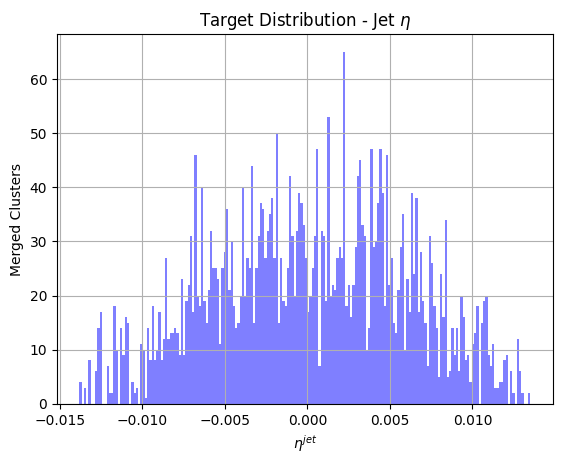

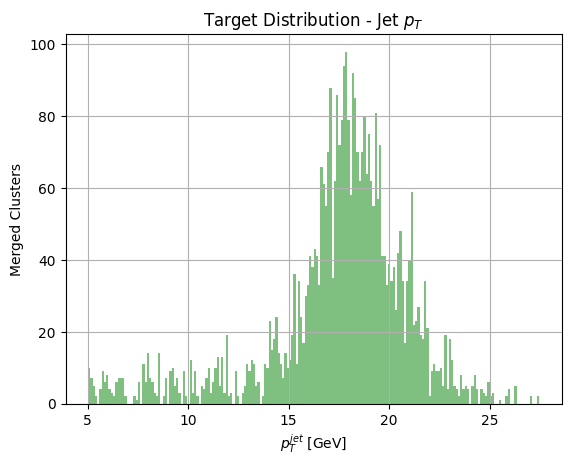

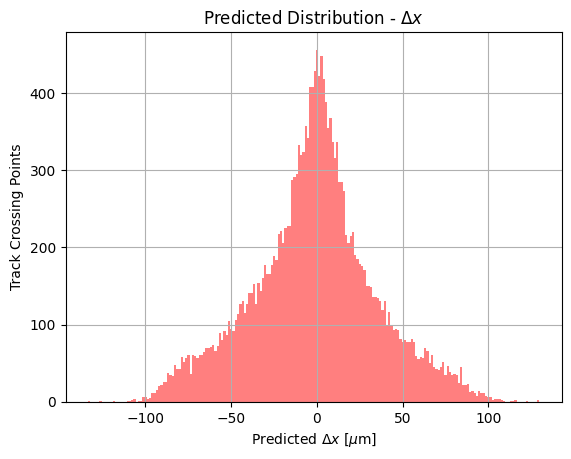

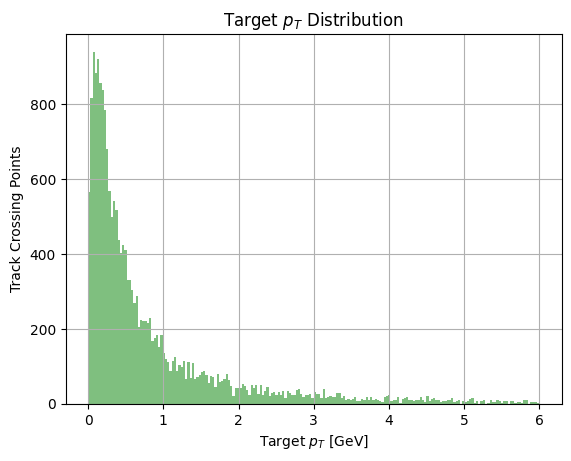

In [12]:
#Plot jet eta and jet pt for all merged clusters. Hint: this does not require TCPs.


# calculates arrays
N = 3799

jet_eta_data = []
jet_pt_data = []

for i in range(N):
    jet_eta_data.append(0.01 * chunk[0][1][i])
    jet_pt_data.append(0.01 * chunk[0][2][i])
    
    

# plots both histograms  

plt.hist(jet_eta_data, bins=200, color='blue', alpha=0.5)
plt.title('Target Distribution - Jet $\eta$ ')
plt.xlabel('$\eta^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()
plt.hist(jet_pt_data, bins=200, color='green', alpha=0.5)
plt.title('Target Distribution - Jet $p_T$')
plt.xlabel('$p_T^{jet}$ [GeV]')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()



#Plot "predicted dx" for every TCP (every pixel that satisifies the condition above). Hint: my printouts above are very helpful.


predicted_dx_data = []

for i in range(N): # for each merged cluster
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8): # if conditions satisfied, append to dataset
                    predicted_dx_data.append(100 * validation_par[i,j,k,l,0])

# plots hists
plt.hist(predicted_dx_data, bins = 200, color="red", alpha = 0.5)
plt.title("Predicted Distribution - $\Delta x$")
plt.xlabel("Predicted $\Delta x$ [$\mu$m]")
plt.ylabel("Track Crossing Points")
plt.grid(True)
#plt.savefig("TCP_predicted_dx.png")
plt.show()




#Plot "target pt" for every TCP. Hint: I said pt, not 1/pt.

target_pt_data = []

for i in range(N): # for each merged cluster
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8): # if conditions satisfied, append to dataset
                    target_pt_data.append(0.01/chunk[1][0][i][j][k][l][4])

# plots hists                  
plt.hist(target_pt_data, bins = 200, color="green", range = (0,6), alpha = 0.5)
plt.title("Target $p_T$ Distribution")
plt.xlabel("Target $p_T$ [GeV]")
plt.ylabel("Track Crossing Points")
plt.grid(True)
#plt.savefig("TCP_target_pt.png")
plt.show()






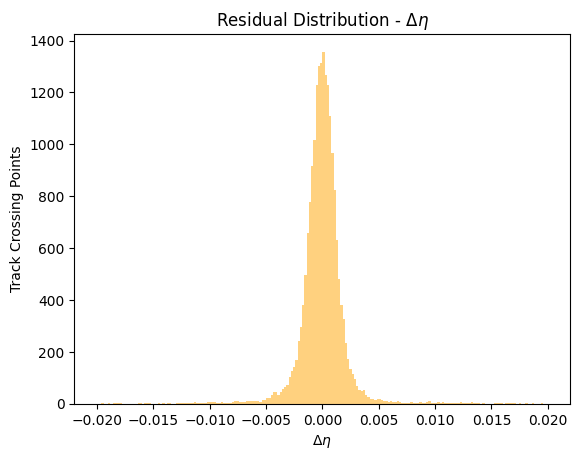

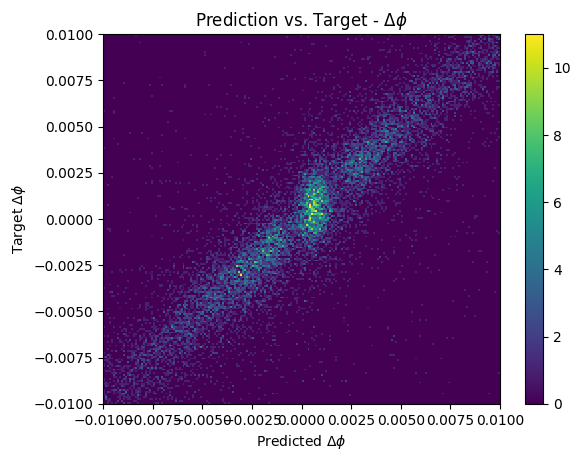

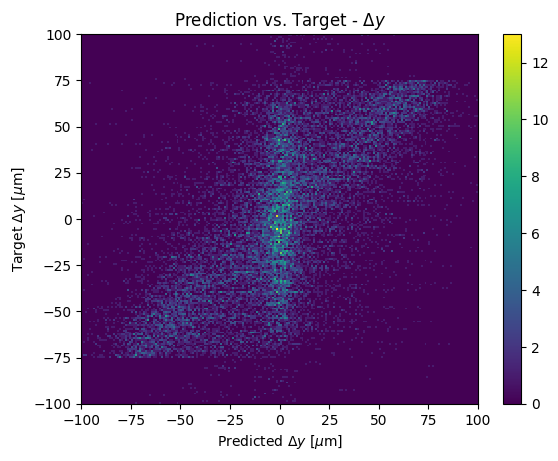

In [13]:
# Plot "residual deta" for every TCP. Hint: Residual means (prediction - target).

residuals_data = []

for i in range(N): # for each merged cluster
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8):
                    residual = validation_par[i,j,k,l,2] - chunk[1][0][i][j][k][l][2] 
                    residuals_data.append(0.01*residual)

# plots hist
plt.hist(residuals_data, bins = 200, range=(-.02,.02), color="orange", alpha = 0.5)
plt.title("Residual Distribution - $\Delta \eta$")
plt.xlabel("$\Delta \eta$")
plt.ylabel("Track Crossing Points")
#plt.savefig("TCP_residual_deta.png")
plt.show()


# Plot "predicted dphi vs target dphi" for every TCP. Hint: look up plt.hist2d function and colorbar.

predicted_dphi_data = []
target_dphi_data = []

for i in range(N): # for each merged cluster
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8):
                    target_dphi_data.append(0.01*chunk[1][0][i][j][k][l][3])
                    predicted_dphi_data.append(0.01*validation_par[i,j,k,l,3])
    
# plots hist
heatmap, xedges, yedges, _ = plt.hist2d(predicted_dphi_data, target_dphi_data, bins=200, range = [(-.01,.01), (-.01,.01)], cmap='viridis')
cbar = plt.colorbar()
plt.title("Prediction vs. Target - $\Delta \phi$")
plt.xlabel("Predicted $\Delta \phi$")
plt.ylabel("Target $\Delta \phi$")
#plt.savefig("TCP_predicted_and_target_dphi.png")

plt.show()

#Plot "predicted dy vs target dy" only if the sum of charge on layer 2 is nonzero. Hint: look up how how to sum arrays along a particular axis.


# gets charge on layer
def getCharge(cluster, layer):
    charge = 0
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                charge = charge + chunk[0][0][cluster][j][k][layer]
    return charge

predicted_dy_data = []
target_dy_data = []
    
    
 # if layer 2 is non-zero 
for i in range(N): # for each merged cluster
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8):
                    predicted_dy_data.append(100 * validation_par[i,j,k,l,1])
                    target_dy_data.append(100*chunk[1][0][i][j][k][l][1])

heatmap, xedges, yedges, _ = plt.hist2d(predicted_dy_data, target_dy_data, range = [(-100,100), (-100,100)], bins=200, cmap='viridis')
cbar = plt.colorbar()
plt.title("Prediction vs. Target - $\Delta y$")
plt.xlabel("Predicted $\Delta y$ [$\mu$m]")
plt.ylabel("Target $\Delta y$ [$\mu$m]")
#plt.savefig("TCP_predicted_and_target_dy.png")
plt.show() 






In [14]:
# Plot target, prediction, residuals and prediction vs target for all 5 parameters (4*5 = 20 plots). 
# Also make sure to comment on any plots that have an interesting feature.


# references: 
# Prediction parameters: validation_par[merged_cluster, x, y, track, [dx, dy, deta, dphi, 1/pt, zero_flag]]
# Target parameters: chunk[1][0][merged_cluster][x][y][track][dx,dy,deta,dphi,1/pt,prob_flag] 

big_data = [
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
] # big_data[parameter][prediction or target][entry]

for i in range(N): # for each merged cluster
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_true_prob == 1 and pixel_pred_prob >= 0.7): # TCP check
                    for a in range(5): # for each parameter
                        if a == 0 or a == 1:
                            b = 100
                        if a == 2 or a == 3: # sets scaling factor
                            b = 0.01
                        if a == 4:
                            b = 1
                        big_data[a][0].append(b * validation_par[i, j, k, l, a]) # append the prediction column of the parameter
                        big_data[a][1].append(b * chunk[1][0][i][j][k][l][a])# append the target column of the parameter

                        
# flips the 1/pt
for i in range(len(big_data[4][0])):
    big_data[4][0][i] = 1/big_data[4][0][i]
    big_data[4][1][i] = 1/big_data[4][1][i]
                    
def makePlot(histdim = 1, parameter = 0, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "red", title = "title", xaxis = "xaxis", yaxis = "yaxis", pltrange = [(-1,1),(-1,1)], savename = "savename.png"):
    if histdim == 1:
        if residuals == False:
            plt.hist(big_data[parameter][pred_targ][:], bins = binnum, color= pltcolor, range = pltrange, alpha = 0.5)
            plt.title(title)
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.grid(True)
            #plt.savefig(savename)
            plt.show()
        else:
            resid = []
            for i in range(len(big_data[parameter][0])):
                resid.append(big_data[parameter][0][i]-big_data[parameter][1][i])
            plt.hist(resid, bins = binnum, color= pltcolor, range = pltrange, alpha = 0.5)
            plt.title(title)
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.grid(True)
            #plt.savefig(savename)
            plt.show()
    if histdim == 2:
        heatmap, xedges, yedges, _ = plt.hist2d(big_data[parameter][1][:], big_data[parameter][0][:], bins = binnum, range = pltrange, alpha = 0.5, cmap = 'viridis')
        cbar = plt.colorbar()
        plt.title(title)
        plt.xlabel(yaxis) # this is on purpose, easiest way to flip
        plt.ylabel(xaxis)
        l_pt = pltrange[0]
        plt.plot(l_pt, l_pt, color='black')
        #plt.savefig(savename)
        plt.show()
    else: 
        return



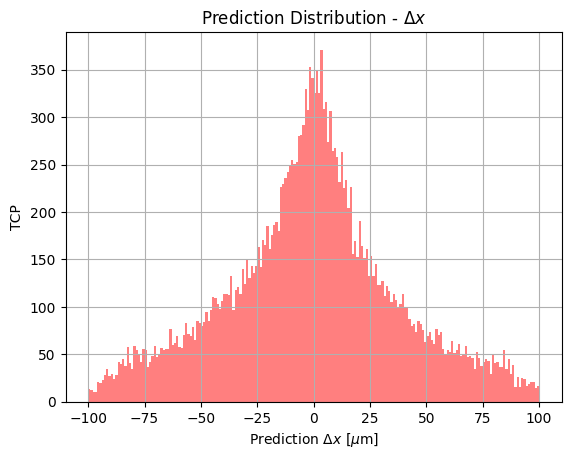

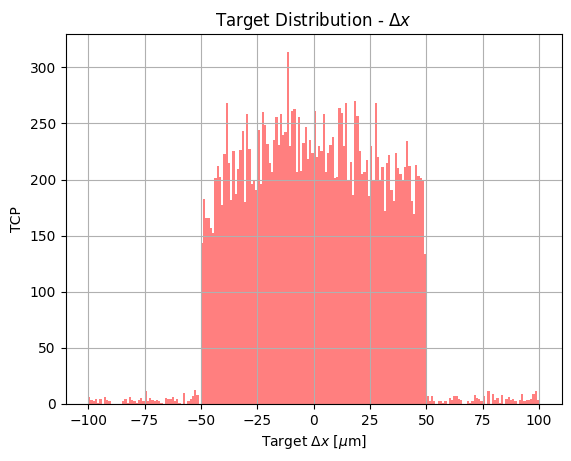

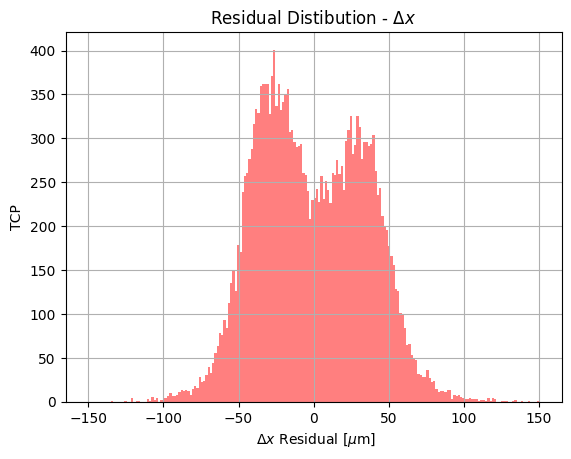

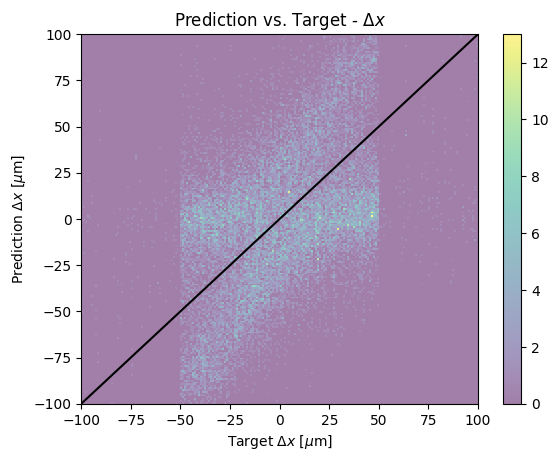

In [15]:
makePlot(histdim = 1, parameter = 0, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "red", title = "Prediction Distribution - $\Delta x$", xaxis = "Prediction $\Delta x$ [$\mu$m]", yaxis = "TCP", pltrange = (-100,100), savename = "predictiondx.png")
makePlot(histdim = 1, parameter = 0, residuals = False, pred_targ = 1, binnum = 200, pltcolor = "red", title = "Target Distribution - $\Delta x$", xaxis = "Target $\Delta x$ [$\mu$m]", yaxis = "TCP", pltrange = (-100,100), savename = "targetdx.png")
makePlot(histdim = 1, parameter = 0, residuals = True, pred_targ = 0, binnum = 200, pltcolor = "red", title = "Residual Distibution - $\Delta x$", xaxis = " $\Delta x$ Residual [$\mu$m]", yaxis = "TCP",  pltrange = (-150,150), savename = "residualdx.png")
makePlot(histdim = 2, parameter = 0, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "red", title = "Prediction vs. Target - $\Delta x$", xaxis = "Prediction $\Delta x$ [$\mu$m]", yaxis = "Target $\Delta x$ [$\mu$m]",  pltrange = [(-100,100),(-100,100)], savename = "pred_v_target_dx.png")

# dx plots (above)


With respect to the predicted and target plots, the target plot drops off fairly sharply, while the predicted smoothly drops off. This likely is due to the distribution that is being fitted being smooth or of some certain type, but could be improved on. The residuals are also bimodal. With respect to the 2-d histogram, I see somewhere between 2-3 trends. First is what appears to be a line of mapping a number of target dx's to 0, second and third are linear relations offset by some value, but suggesting a correlation.

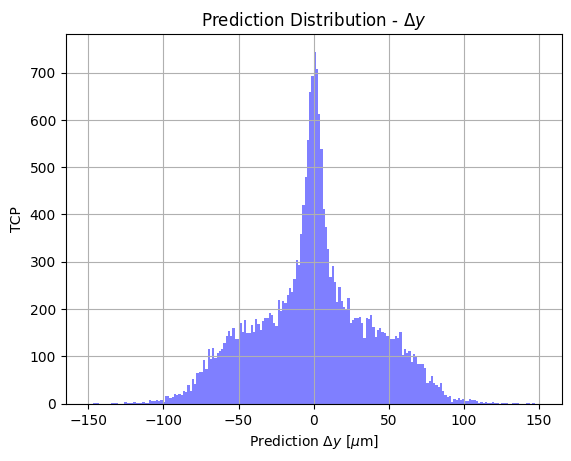

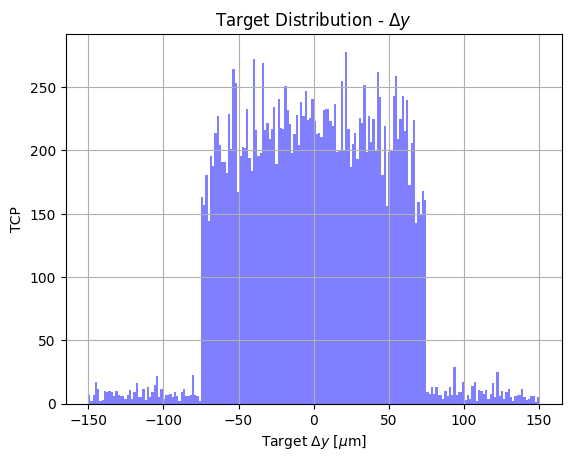

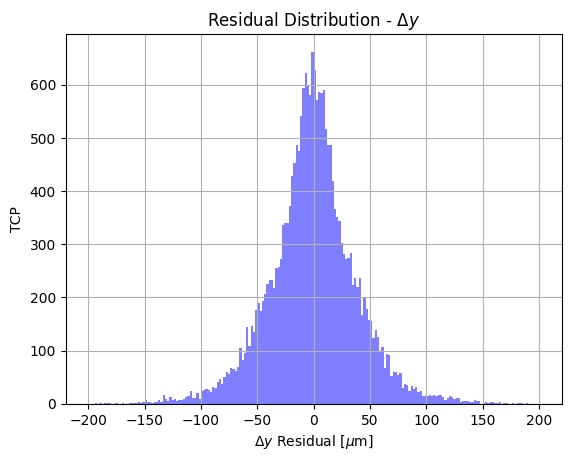

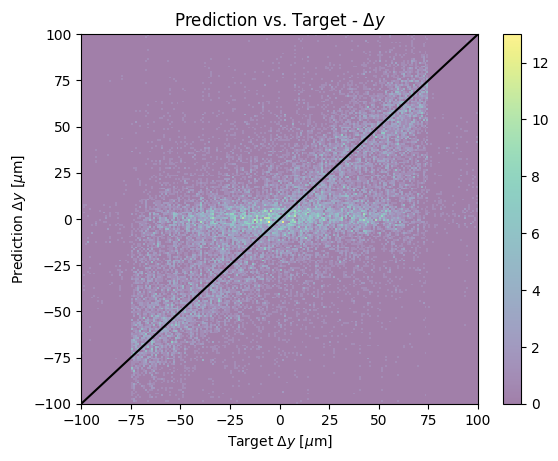

In [16]:
makePlot(histdim = 1, parameter = 1, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "blue", title = "Prediction Distribution - $\Delta y$", xaxis = "Prediction $\Delta y$ [$\mu$m]", yaxis = "TCP", pltrange = (-150,150), savename = "predictiondy.png")
makePlot(histdim = 1, parameter = 1, residuals = False, pred_targ = 1, binnum = 200, pltcolor = "blue", title = "Target Distribution - $\Delta y$", xaxis = "Target $\Delta y$ [$\mu$m]", yaxis = "TCP", pltrange = (-150,150),savename = "targetdy.png")
makePlot(histdim = 1, parameter = 1, residuals = True, pred_targ = 0, binnum = 200, pltcolor = "blue", title = "Residual Distribution - $\Delta y$", xaxis = "$\Delta y$ Residual [$\mu$m]", yaxis = "TCP", pltrange = (-200,200), savename = "residualdy.png")
makePlot(histdim = 2, parameter = 1, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "blue", title = "Prediction vs. Target - $\Delta y$", xaxis = "Prediction $\Delta y$ [$\mu$m]", yaxis = "Target $\Delta y$ [$\mu$m]", pltrange = ((-100,100),(-100,100)), savename = "pred_v_target_dy.png")

# dy plots (above)

With respect to the individual predicted and target plots, the dy plots have a similar issue of the prediction not being able to accurately replicate the sharp drop off of the target. I see the same "mapping to 0" trend in the 2-d histogram, but here I see clearly only one linear correlation, not what may be two that are offset, and a unimodal residual distribution.

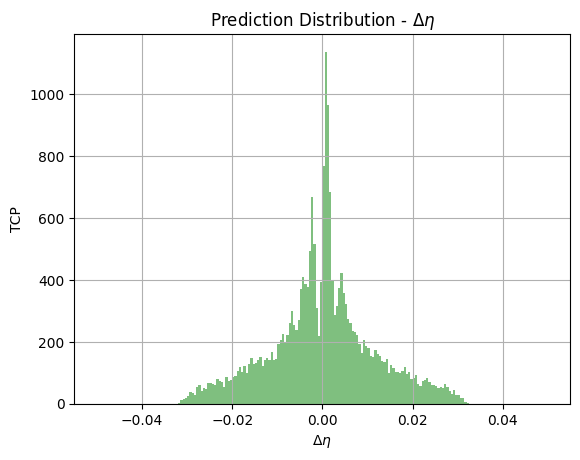

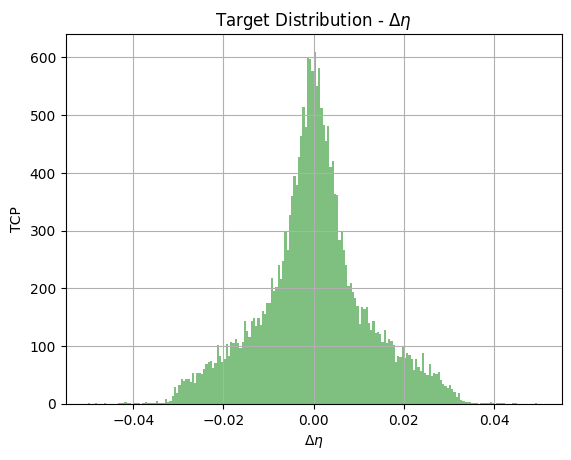

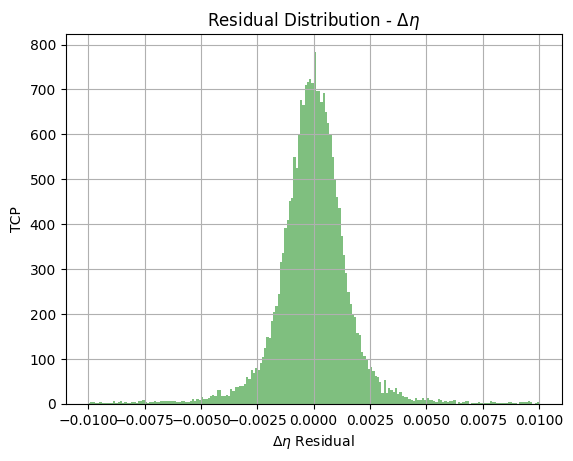

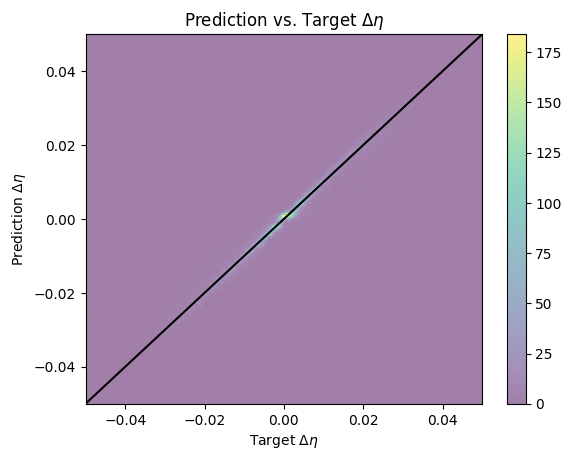

In [17]:
makePlot(histdim = 1, parameter = 2, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "green", title = "Prediction Distribution - $\Delta \eta$", xaxis = "$\Delta \eta$", yaxis = "TCP", pltrange = (-.05,.05), savename = "predictiondeta.png")
makePlot(histdim = 1, parameter = 2, residuals = False, pred_targ = 1, binnum = 200, pltcolor = "green", title = "Target Distribution - $\Delta \eta$", xaxis = "$\Delta \eta$", yaxis = "TCP",  pltrange= (-.05,.05), savename = "targetdeta.png")
makePlot(histdim = 1, parameter = 2, residuals = True, pred_targ = 0, binnum = 200, pltcolor = "green", title = "Residual Distribution - $\Delta \eta$", xaxis = "$\Delta \eta$ Residual", yaxis = "TCP", pltrange = (-.01,.01), savename = "residualdeta.png")
makePlot(histdim = 2, parameter = 2, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "green", title = "Prediction vs. Target $\Delta \eta$", xaxis = "Prediction $\Delta \eta$", yaxis = "Target $\Delta \eta$", pltrange = [(-.05,.05),(-.05,.05)], savename = "pred_v_target_deta.png")

# deta plots (above)

For the prediction and target plots, it appears that the prediction distribution is able to approximate the target adequately, save for a few gaps near deta = 0. Hence, I see a unimodal residual distribution and a strongly correlated 2d histogram.

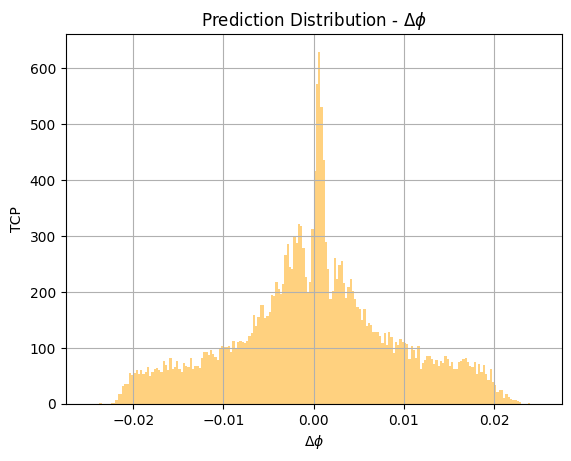

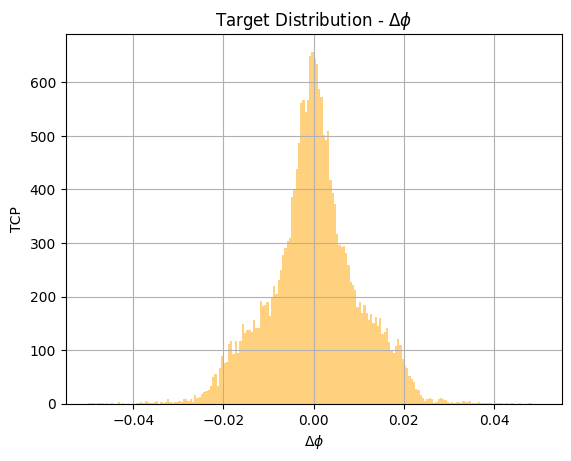

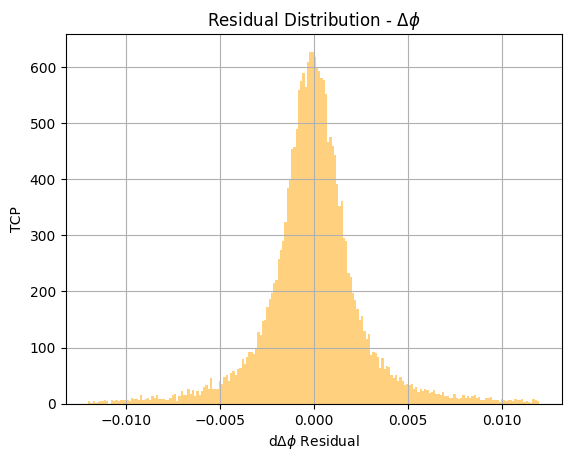

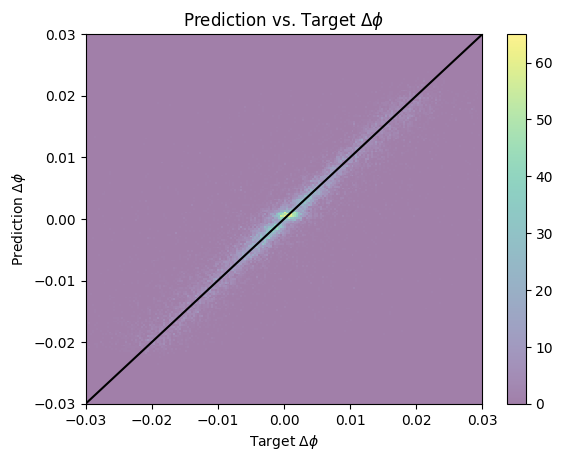

In [18]:
makePlot(histdim = 1, parameter = 3, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "orange", title = "Prediction Distribution - $\Delta \phi$", xaxis = "$\Delta \phi$", yaxis = "TCP", pltrange = (-.025,.025), savename = "predictiondphi.png")
makePlot(histdim = 1, parameter = 3, residuals = False, pred_targ = 1, binnum = 200, pltcolor = "orange", title = "Target Distribution - $\Delta \phi$", xaxis = "$\Delta \phi$", yaxis = "TCP", pltrange = (-.05,.05), savename = "targetdphi.png")
makePlot(histdim = 1, parameter = 3, residuals = True, pred_targ = 0, binnum = 200, pltcolor = "orange", title = "Residual Distribution - $\Delta \phi$", xaxis = "d$\Delta \phi$ Residual", yaxis = "TCP", pltrange = (-.012,.012), savename = "residualdphi.png")
makePlot(histdim = 2, parameter = 3, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "orange", title = "Prediction vs. Target $\Delta \phi$", xaxis = "Prediction $\Delta \phi$", yaxis = "Target $\Delta \phi$", pltrange = ((-.03,.03),(-.03,0.03)), savename = "pred_v_target_dphi.png")

# dphi plots (above)

As with deta, for the prediction and target plots, it appears that the prediction distribution is able to approximate the target adequately, save for a few gaps near dphi = 0. Hence, I see a unimodal residual distribution and a strongly correlated 2d histogram. There is however a small region near dphi = 0 where the entire neighborhood is being mapped to 0.

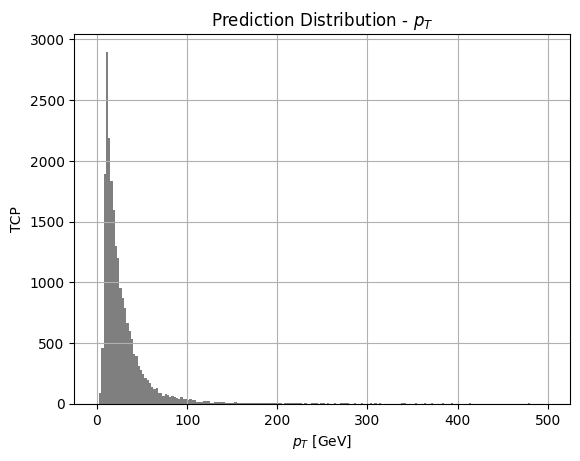

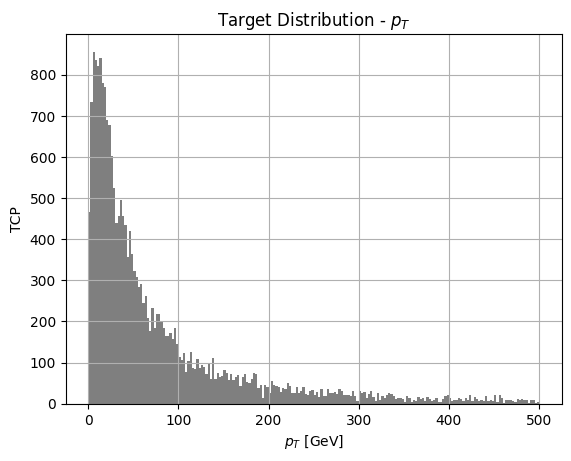

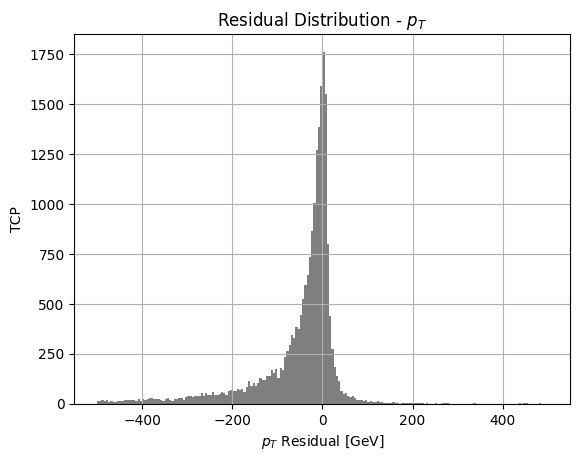

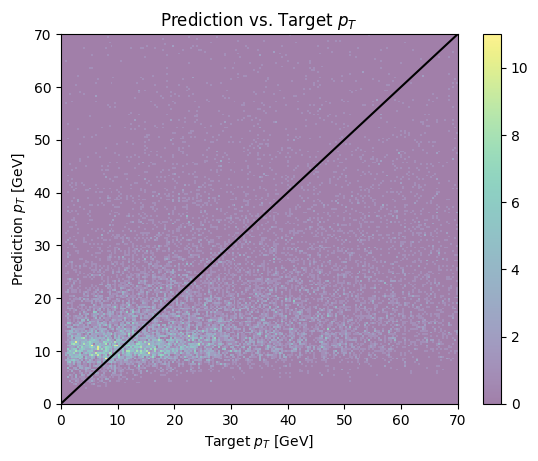

In [19]:
makePlot(histdim = 1, parameter = 4, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "black", title = "Prediction Distribution - $p_T$", xaxis = "$p_T$ [GeV]", yaxis = "TCP", pltrange = (0,500), savename = "predictionpt.png")
makePlot(histdim = 1, parameter = 4, residuals = False, pred_targ = 1, binnum = 200, pltcolor = "black", title = "Target Distribution - $p_T$", xaxis = "$p_T$ [GeV]", yaxis = "TCP", pltrange = (0,500),savename = "targetpt.png")
makePlot(histdim = 1, parameter = 4, residuals = True, pred_targ = 0, binnum = 200, pltcolor = "black", title = "Residual Distribution - $p_T$", xaxis = "$p_T$ Residual [GeV]", yaxis = "TCP", pltrange = (-500,500), savename = "residualpt.png")
makePlot(histdim = 2, parameter = 4, residuals = False, pred_targ = 0, binnum = 200, pltcolor = "black", title = "Prediction vs. Target $p_T$", xaxis = "Prediction $p_T$ [GeV]", yaxis = "Target $p_T$ [GeV]", pltrange = [(0,70),(0,70)], savename = "pred_v_target_pt.png")

# pt plots (above)


Here, the target and predicted distributions have similar shapes, yet the predicted distribution falls off or undershoots, which leads to large negative residuals. Additionally, in the 2d histogram, I see a trend of sending many of the target pt's to 10 GeV, and an absence of a strong linear correlation.

# deepcore threshold discussion

from what I see, the point of

prob_threshold = [0.7, 0.85, 1] 

and 

if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1)

is to have different validation criteria for a TCP per layer. The inner layers have smaller thresholds, which increase as the track is traced outward. How I interpret this is that we can take slightly "worse" or unlikely points during the first layer, but that our criteria for a good point gets far stricter as we move out. I would imagine this is because, in the first layer, the jets are closer together than they would be at a farther distance from the beam, where they would have spread out more. I imagine it would be more difficult to tell them apart/determine pixels at these early stages because of this density, so the threshold is lower. Just a conjecture though; could be completely wrong.

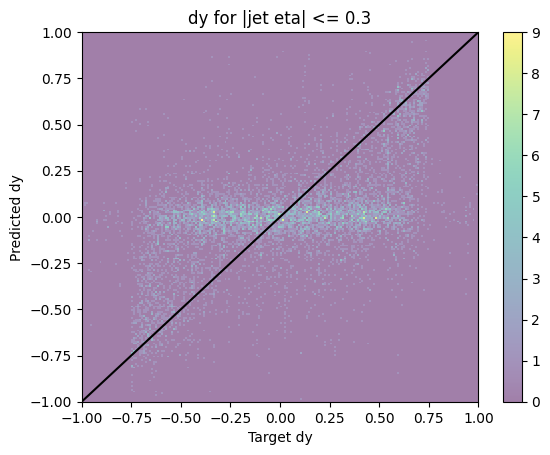

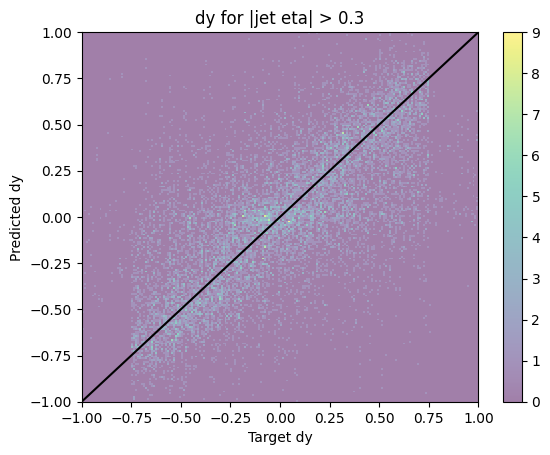

In [20]:
#  plot dy for |jet eta| <= 0.3 then |jet eta| > 0.3 and comment on the resulting plots.


dys_pred = []
dys_target = []

for i in range(N): # for each merged cluster
    if abs(chunk[0][1][i]) <= 0.3: # for clusters with certain jet eta
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8): # TCP check
                        dys_pred.append(validation_par[i, j, k, l, 1]) # append pred dy's
                        dys_target.append(chunk[1][0][i][j][k][l][1]) # append target dy's

heatmap, xedges, yedges, _ = plt.hist2d(dys_target, dys_pred, bins = 200, alpha = 0.5, range = [(-1,1),(-1,1)], cmap = 'viridis')
cbar = plt.colorbar()
plt.title("dy for |jet eta| <= 0.3")
plt.ylabel("Predicted dy")
plt.xlabel("Target dy")
#plt.savefig("dy<=.png")
l_pt = (-1,1)
plt.plot(l_pt, l_pt, color='black')
plt.show()


dys_pred = []
dys_target = []

for i in range(N): # for each merged cluster
    if abs(chunk[0][1][i]) > 0.3: # for clusters with certain jet eta
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_true_prob == 1 and pixel_pred_prob >= 0.8): # TCP check
                        dys_pred.append(validation_par[i, j, k, l, 1]) # append pred dy's
                        dys_target.append(chunk[1][0][i][j][k][l][1]) # append target dy's

heatmap, xedges, yedges, _ = plt.hist2d(dys_target, dys_pred, bins = 200, alpha = 0.5, range = [(-1,1),(-1,1)], cmap = 'viridis')
cbar = plt.colorbar()
plt.title("dy for |jet eta| > 0.3")
plt.ylabel("Predicted dy")
plt.xlabel("Target dy")
#plt.savefig("dy>.png")
l_pt = (-1,1)
plt.plot(l_pt, l_pt, color='black')
plt.show()


# dy for jet eta values (above)

For the jet eta split plots, both cases have some strongly correlated trend and some "send to 0" trend. However, in the lower magnitude case, this "send to 0" trend is far stronger, while in the higher magnitude case, the neural network is able to predict the dy's better, leading to a more distinct correlation

In [21]:
# investigating interesting plot features

prob_threshold = [0.7, 0.85, 1] 
prob_dth_l134 = [0.1, 0.05, 0]
prob_dth_l2 = [0.3, 0.15, 0]


def getStats(arr):
    stats = []
    for i in range(len(arr[0])): # for each component of a parameter vector
        vals = []
        vals.append(np.mean(arr[:,i])) # mean
        vals.append(np.std(arr[:,i])) # std
        stats.append(np.array(vals))
    return stats # returns vector of forms [[p1_mean,p1_std],[p2_mean,p2_std],...]

def getdxSummary(resid_cutoff, acc_cutoff):
    highs = np.array([[0,0,0,0],[0,0,0,0]], dtype = float)
    lows = np.array([[0,0,0,0],[0,0,0,0]], dtype = float)
    accs = np.array([[0,0,0,0],[0,0,0,0]], dtype = float)
    #param_vector of form param_vector[charge dep, jet eta, jet pt, pred prob]
    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                        if (big_data[0][0][i]-big_data[0][1][i] > resid_cutoff): # high residual
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob]                      
                            highs = np.append(highs, [param_vector], axis=0)
                        
                        if (big_data[0][0][i]-big_data[0][1][i] < -resid_cutoff): # low residual
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob]                        
                            lows = np.append(lows, [param_vector], axis=0)

                        if (abs(big_data[0][0][i]-big_data[0][1][i]) < acc_cutoff): # fairly accurate
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob]                     
                            accs = np.append(accs, [param_vector], axis=0)
    high_stats = getStats(highs)
    low_stats = getStats(lows)
    acc_stats = getStats(accs)
    print("DX SUMMARY:")
    for i in range(4):
        if i == 0:
            print("Mean Charge:")
        if i == 1:
            print("Mean jet eta:")
        if i == 2:
            print("Mean jet pT:")
        if i == 3:
            print("Mean Predicted Prob:")
        print("Negative Residuals: " + str(low_stats[i][0]) + " with standard deviation " + str(low_stats[i][1]))
        print("Positive Residuals: " + str(high_stats[i][0]) + " with standard deviation " + str(high_stats[i][1]))
        print("Accurate Residuals: " + str(acc_stats[i][0]) + " with standard deviation " + str(acc_stats[i][1]))
        

def getdySummary(resid_cutoff, acc_cutoff):
    highs = np.array([[0,0,0,0],[0,0,0,0]], dtype = float)
    lows = np.array([[0,0,0,0],[0,0,0,0]], dtype = float)
    accs = np.array([[0,0,0,0],[0,0,0,0]], dtype = float)
    #param_vector of form param_vector[charge dep, jet eta, jet pt, pred prob]
    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                        if (big_data[1][0][i]-big_data[1][1][i] > resid_cutoff): # high residual
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob]                      
                            highs = np.append(highs, [param_vector], axis=0)
                        
                        if (big_data[1][0][i]-big_data[1][1][i] < -resid_cutoff): # low residual
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob]                        
                            lows = np.append(lows, [param_vector], axis=0)

                        if (abs(big_data[1][0][i]-big_data[1][1][i]) < acc_cutoff): # fairly accurate
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob]                     
                            accs = np.append(accs, [param_vector], axis=0)
    high_stats = getStats(highs)
    low_stats = getStats(lows)
    acc_stats = getStats(accs)
    print("DY SUMMARY")
    for i in range(4):
        if i == 0:
            print("Mean Charge:")
        if i == 1:
            print("Mean jet eta:")
        if i == 2:
            print("Mean jet pT:")
        if i == 3:
            print("Mean Predicted Prob:")
        print("Negative Residuals: " + str(low_stats[i][0]) + " with standard deviation " + str(low_stats[i][1]))
        print("Positive Residuals: " + str(high_stats[i][0]) + " with standard deviation " + str(high_stats[i][1]))
        print("Accurate Residuals: " + str(acc_stats[i][0]) + " with standard deviation " + str(acc_stats[i][1]))
    

In [22]:

# splitting dx w.r.t. jet eta

def graphsplitdxeta(threshold):

    dxs_pred = []
    dxs_target = []
# just use target = 1 as above
    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        if chunk[0][1][i] <= threshold: # for clusters with certain jet pt
            for j in range(30): # for each x value
                for k in range(30): # for each y value
                    for l in range(3): # for each track
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                            dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target.append(100*chunk[1][0][i][j][k][l][0]) 
    
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5, cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for jet eta <= " + str(threshold))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    
    plt.show()

    dxs_pred = []
    dxs_target = []

    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        if chunk[0][1][i] > threshold: # for clusters with certain jet pt
            for j in range(30): # for each x value
                for k in range(30): # for each y value
                    for l in range(3): # for each track
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                            dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target.append(100*chunk[1][0][i][j][k][l][0]) 
 
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5, cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for jet eta > " + str(threshold))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    
    plt.show()

    

    
    
    
    


In [23]:

# splitting dx w.r.t. jet pt

def graphsplitdxpt(threshold):

    dxs_pred = []
    dxs_target = []

    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        if chunk[0][2][i] <= threshold: # for clusters with certain jet pt
            for j in range(30): # for each x value
                for k in range(30): # for each y value
                    for l in range(3): # for each track
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                            dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target.append(100*chunk[1][0][i][j][k][l][0]) 

    
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5, cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for jet pt <= " + str(threshold))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    
    plt.show()
    

    dxs_pred = []
    dxs_target = []

    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        if chunk[0][2][i] > threshold: # for clusters with certain jet pt
            for j in range(30): # for each x value
                for k in range(30): # for each y value
                    for l in range(3): # for each track
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                            dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target.append(100*chunk[1][0][i][j][k][l][0]) 
    
   
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5, cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for jet pt > " + str(threshold))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    
    plt.show()
    


In [24]:
# investigating charge effect

def graphsplitdxcharge(threshold):

    dxs_pred = []
    dxs_target = []

    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    if chunk[0][0][i][j][k][l] <= threshold:
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                            dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target.append(100*chunk[1][0][i][j][k][l][0]) 
                            
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5,  cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for charge <= " + str(threshold))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    
    plt.show()

    dxs_pred = []
    dxs_target = []

    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    if chunk[0][0][i][j][k][l] > threshold:
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                            dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target.append(100*chunk[1][0][i][j][k][l][0]) 
 
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5,  cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for charge > " + str(threshold))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    
    plt.show()
    

In [25]:
# positive and negative predictions
def getdxsplitSummary(threshold1, threshold2):
    close = np.array([[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]], dtype = float)
    far = np.array([[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]], dtype = float)
    #param_vector of form param_vector[charge dep, jet eta, jet pt, pred prob, targ_dx, targ_dy, targ_deta, targ_dphi, targ_1/pt]
    #chunk[1][0][merged_cluster][x][y][track][dx,dy,deta,dphi,1/pt,prob_flag]
    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                        if abs(100*validation_par[i, j, k, l, 0] - 100*chunk[1][0][i][j][k][l][0]) > threshold2:
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob, 100*chunk[1][0][i][j][k][l][0], 100*chunk[1][0][i][j][k][l][1], .01*chunk[1][0][i][j][k][l][2], .01*chunk[1][0][i][j][k][l][3], chunk[1][0][i][j][k][l][4]]                     
                            far = np.append(far, [param_vector], axis=0)
                        if abs(100*validation_par[i, j, k, l, 0] - 100*chunk[1][0][i][j][k][l][0]) < threshold1:
                            param_vector = [chunk[0][0][i][j][k][l], chunk[0][1][i], chunk[0][2][i], pixel_pred_prob, 100*chunk[1][0][i][j][k][l][0], 100*chunk[1][0][i][j][k][l][1], .01*chunk[1][0][i][j][k][l][2], .01*chunk[1][0][i][j][k][l][3], chunk[1][0][i][j][k][l][4]]                     
                            close = np.append(close, [param_vector], axis=0)
                        
    far_stats=getStats(far)
    close_stats=getStats(close)
    labels = ["Mean Charge:", "Mean jet eta:", "Mean jet pT:", "Mean Predicted Prob:", "Mean target dx:", "Mean target dy:", "Mean target deta:", "Mean target dphi:", "Mean target 1/pt:"]
    
    
    
    
    print("DX CLOSE PREDICTION SUMMARY: distance < " + str(threshold1))
    for i in range(len(labels)):
        print(labels[i])
        print(str(round(far_stats[i][0],3)) + " with standard deviation " + str(round(far_stats[i][1],3)))
    print("")   
    print("DX FAR PREDICTION SUMMARY: distance >" + str(threshold2))
    for i in range(len(labels)):
        print(labels[i])
        print(str(round(close_stats[i][0],3)) + " with standard deviation " + str(round(close_stats[i][1],3)))
    print("")    
    
 





In [26]:
# divides into three regions based on eta

def graphsplitdxtrip(threshold1, threshold2):

    dxs_pred1 = []
    dxs_target1 = []
    dxs_pred2 = []
    dxs_target2 = []
    dxs_pred3 = []
    dxs_target3 = []

    for i in range(N): # for each merged cluster
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                        if chunk[0][1][i] > threshold2: # switch to chunk[0][2][i] for jet pt
                            dxs_pred1.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target1.append(100*chunk[1][0][i][j][k][l][0]) 
                        if chunk[0][1][i] < threshold1:
                            dxs_pred2.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target2.append(100*chunk[1][0][i][j][k][l][0]) 
                        else:
                            dxs_pred3.append(100*validation_par[i, j, k, l, 0]) 
                            dxs_target3.append(100*chunk[1][0][i][j][k][l][0]) 
                            
                        
                            
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target1, dxs_pred1, bins = 200, alpha = 0.5,  cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for eta > " + str(threshold2))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    plt.show()
 
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target2, dxs_pred2, bins = 200, alpha = 0.5,  cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for eta < " + str(threshold1))
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    plt.show()
    
    heatmap, xedges, yedges, _ = plt.hist2d(dxs_target3, dxs_pred3, bins = 200, alpha = 0.5,  cmap = 'viridis')
    cbar = plt.colorbar()
    plt.title("dx for intermediate eta")
    plt.ylabel("Predicted dx")
    plt.xlabel("Target dx")
    plt.show()
    
    

In [27]:
## k-means for target and predicted


from sklearn.cluster import KMeans


def getdxkmeans(k):
    
    data = np.array([[1,0], [1,0]])

    for i in range(len(big_data[0][0])):
        data = np.append(data, [[big_data[0][0][i], big_data[0][1][i]]], axis = 0)

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_


    plt.scatter(data[:, 1], data[:, 0], c=labels, cmap='viridis')
    plt.scatter(centers[:, 1], centers[:, 0], c='red', marker='x', label='Cluster Centers')
    plt.xlabel('Target dx')
    plt.ylabel('Prediction dx')
    plt.legend()
    plt.show()


# Functions


In [28]:
# will print summary statistics for dx and dy for 3 residual groups: positive, negative, near 0


In [29]:
# will plot 2 pred-targ dx graphs for points with eta's bounded by input


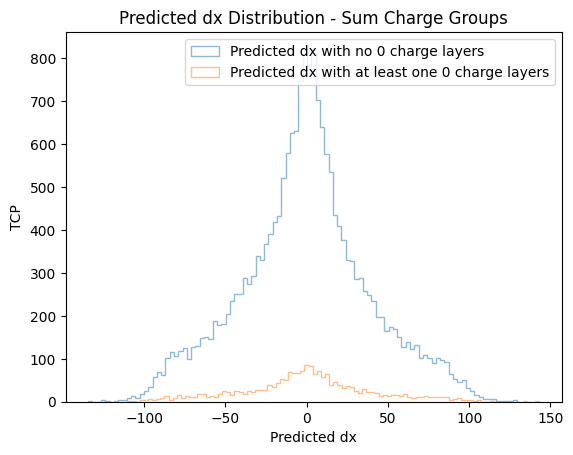

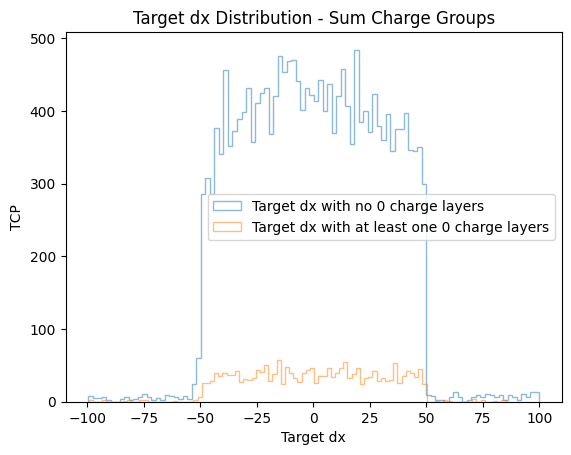

In [30]:
# distribution when there's charge 0 layers

# gets charge on layer for cluster
def getCharge(cluster, layer):
    charge = 0
    for j in range(30): # for each x value
        for k in range(30): # for each y value
            charge = charge + chunk[0][0][cluster][j][k][layer]
    return charge

preddx_zero=[]
preddx_nonzero=[]
targdx_zero=[]
targdx_nonzero=[]

for i in range(N): # for each merged cluster
    if (getCharge(i,0) == 0 or getCharge(i,1) == 0 or getCharge(i,2) == 0 or getCharge(i,3)):
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > .7 and pixel_true_prob == 1): 
                        preddx_zero.append(100*validation_par[i, j, k, l, 0]) 
                        targdx_zero.append(100*chunk[1][0][i][j][k][l][0]) 
    else:
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > .7 and pixel_true_prob == 1): 
                        preddx_nonzero.append(100*validation_par[i, j, k, l, 0]) 
                        targdx_nonzero.append(100*chunk[1][0][i][j][k][l][0]) 


plt.hist(preddx_zero, bins=100, alpha=0.5, label='Predicted dx with no 0 charge layers', histtype = 'step')
plt.hist(preddx_nonzero, bins=100, alpha=0.5, label='Predicted dx with at least one 0 charge layers', histtype = 'step')
plt.xlabel('Predicted dx')
plt.ylabel('TCP')
plt.title('Predicted dx Distribution - Sum Charge Groups')
plt.legend()
plt.show()

plt.hist(targdx_zero, bins=100, alpha=0.5, label='Target dx with no 0 charge layers', histtype = 'step')
plt.hist(targdx_nonzero, bins=100, alpha=0.5, label='Target dx with at least one 0 charge layers', histtype = 'step')
plt.xlabel('Target dx')
plt.ylabel('TCP')
plt.title('Target dx Distribution - Sum Charge Groups')
plt.legend()
plt.show()
#density = true


dx          dy        deta      dphi     1/pt     j_eta       j_pt       charge   
0.14     -0.2     0.732     0.118     0.026     -0.341     1880.414     1.852     3
0.138     0.682     0.059     0.182     0.015     -0.847     1741.464     0.657     4
-0.01     0.238     -0.431     -0.24     0.006     0.229     1754.759     0.941     36
0.207     0.675     -0.197     0.204     0.011     -0.698     1565.993     2.33     38
-0.153     0.355     -0.562     2.21     0.027     0.22     1611.466     0.965     55
-0.091     -0.19     -0.677     0.77     0.009     0.48     1171.311     2.524     61
-0.112     0.149     -1.36     -0.684     0.018     -0.686     2064.587     1.118     79
-0.011     0.301     0.237     1.228     0.063     -0.738     1592.953     0.552     86
-0.22     -0.722     0.652     -0.609     0.026     1.059     1638.689     1.129     89
-0.046     0.63     -1.421     -1.61     0.05     -0.361     1915.019     2.093     125
0.358     0.527     -0.452     -0.674     0.034 

-0.418     0.2     -0.163     1.555     0.019     -0.142     927.421     1.516     1259
-0.46     -0.474     0.113     -0.565     0.013     0.151     2593.552     1.181     1274
0.233     0.089     -1.166     -2.158     0.037     0.457     1516.881     0.947     1278
-0.479     -0.222     0.148     0.295     0.006     0.457     1516.881     0.0     1279
-0.374     -0.087     0.291     -0.607     0.035     1.099     2090.782     1.935     1319
-0.374     -0.087     0.291     -0.607     0.035     1.099     2090.782     1.935     1319
-0.196     -0.357     -0.122     -1.71     0.011     -0.23     1786.787     1.388     1326
0.414     0.66     -1.516     -0.95     0.034     0.658     1704.514     0.817     1331
0.015     -0.71     -2.006     0.566     0.104     -0.362     1595.696     1.811     1342
0.361     -0.277     -0.108     -0.046     0.003     -0.384     1917.788     0.767     1367
-0.274     -0.475     -0.059     0.517     0.003     0.908     1960.893     0.0     1370
-0.086     -

-0.275     -0.231     -0.017     -0.374     0.096     0.692     1461.72     0.0     2318
-0.17     -0.241     -0.054     1.704     0.01     0.154     2216.515     1.264     2385
0.042     -0.073     0.251     0.397     0.011     -0.705     2375.303     2.666     2392
0.102     0.064     -0.418     -0.532     0.023     -0.705     2375.303     1.216     2392
0.306     -0.128     -0.327     0.32     0.052     0.345     1913.574     2.443     2401
0.388     0.297     -2.186     -1.763     0.705     0.411     1312.654     2.527     2413
0.23     -0.54     -0.4     -1.893     0.04     -0.222     1688.307     0.355     2426
-0.162     0.57     -0.034     1.312     0.094     0.048     1793.081     1.12     2452
-0.154     -0.629     -2.158     -0.884     0.032     -0.289     1587.21     2.321     2465
-0.031     0.549     -1.551     0.308     0.506     -0.289     1587.21     2.518     2466
0.227     -0.342     0.077     -2.002     0.015     -0.116     1815.551     1.64     2471
-0.106     -0.2

-0.155     0.185     0.529     0.92     0.015     -0.814     1620.913     0.511     3672
0.043     1.002     0.532     0.18     0.017     0.563     1740.353     2.077     3673
-0.163     0.707     0.017     -0.431     0.02     0.563     1740.353     0.922     3675
0.19     0.29     -0.641     0.321     0.052     0.193     1905.585     2.114     3686
-0.05     0.399     0.675     0.264     0.008     0.193     1905.585     0.772     3686
0.025     -0.194     -1.437     -0.218     0.005     0.164     1719.818     1.11     3697
0.042     -0.705     -0.463     -0.294     0.004     -0.229     1623.319     1.597     3700
0.1     -0.556     -1.544     0.971     0.1     0.55     1133.708     1.084     3743
0.056     0.428     -0.213     -0.427     0.01     0.55     1133.708     0.594     3744
0.101     0.75     0.068     0.186     0.009     0.47     2124.546     2.302     3753
0.371     -0.553     -1.755     0.118     0.048     0.47     2124.546     0.996     3755
0.232     0.042     -0.109    

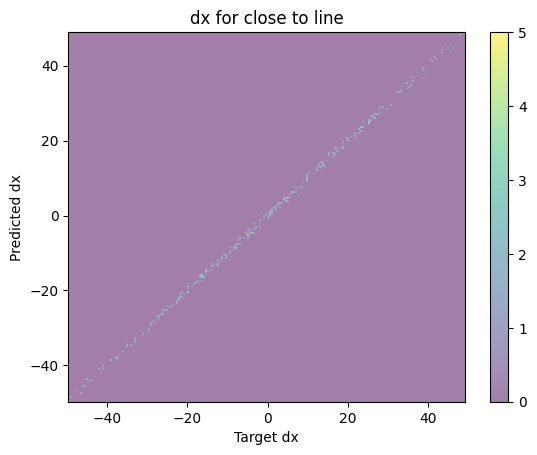

In [31]:
# finding points close to diagonal


dxs_pred = []
dxs_target = []




print("dx          dy        deta      dphi     1/pt     j_eta       j_pt       charge   ")
for i in range(N): # for each merged cluster
    dth_l134 = 1
    dth_l2 = 1
    A = np.array(chunk[0][0][i])
    S= np.sum(A, axis=(0,1))
    if (S[0]*S[2]*S[3]):
        dth_l134 = 0
    if (S[1]):
        dth_l2 = 0
    for j in range(30): # for each x value
        for k in range(30): # for each y value
             for l in range(3): # for each track
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                    if abs(100*validation_par[i, j, k, l, 0] - 100*chunk[1][0][i][j][k][l][0]) < 1:
                        dxs_pred.append(100*validation_par[i, j, k, l, 0]) 
                        dxs_target.append(100*chunk[1][0][i][j][k][l][0])
                        print(str(round(chunk[1][0][i][j][k][l][0],3)) + "     " + str(round(chunk[1][0][i][j][k][l][1],3)) + "     " + str(round(chunk[1][0][i][j][k][l][2],3))+"     "+str(round(chunk[1][0][i][j][k][l][3],3)) +"     "+str(round(chunk[1][0][i][j][k][l][4],3))+"     "+str(round(chunk[0][1][i],3)) +  "     "+str(round(chunk[0][2][i],3))+ "     " + str(round(chunk[0][0][i][j][k][1], 3))+ "     " + str(i))                        
    
heatmap, xedges, yedges, _ = plt.hist2d(dxs_target, dxs_pred, bins = 200, alpha = 0.5, cmap = 'viridis')
cbar = plt.colorbar()
plt.title("dx for close to line")
plt.ylabel("Predicted dx")
plt.xlabel("Target dx")
plt.show()

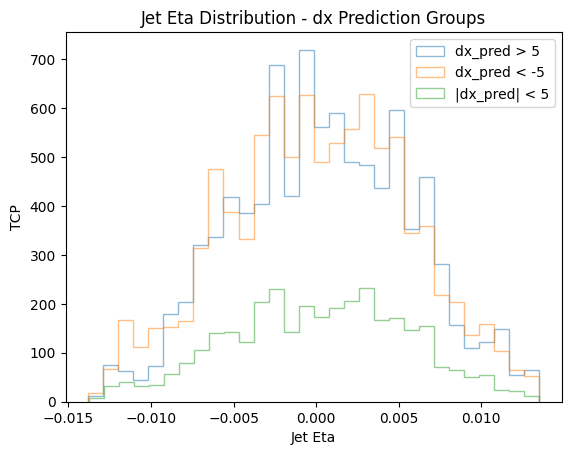

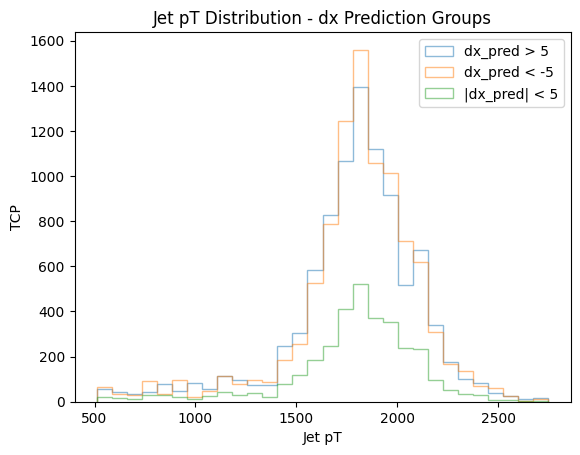

In [32]:
## target dx and dy's of the different positive, negative, and kernel dx_pred groups of pixels



def graphdxtriple(cutoff):
    poseta = []
    negeta= []
    kereta= []
    pospt= []
    negpt = []
    kerpt = []
    threshold = cutoff
    
    
    
    
    for i in range(N): # for each merged cluster
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > .7 and pixel_true_prob == 1): 
                        if ((100*validation_par[i, j, k, l, 0]) > threshold): # pos
                            poseta.append(.01*chunk[0][1][i])
                            pospt.append(chunk[0][2][i])
                        else:
                            if ((100*validation_par[i, j, k, l, 0]) < (-1*threshold)): # neg
                                negeta.append(.01*chunk[0][1][i])
                                negpt.append(chunk[0][2][i])
                            else: # kernel
                                kereta.append(.01*chunk[0][1][i])
                                kerpt.append(chunk[0][2][i])
                            
    plt.hist(poseta, bins=30, alpha=0.5, label='dx_pred > ' + str(cutoff), histtype = 'step')
    plt.hist(negeta, bins=30, alpha=0.5, label='dx_pred < -' + str(cutoff), histtype = 'step')
    plt.hist(kereta, bins=30, alpha=0.5, label='|dx_pred| < ' + str(cutoff), histtype = 'step')
    plt.xlabel('Jet Eta')
    plt.ylabel('TCP')
    plt.title('Jet Eta Distribution - dx Prediction Groups')
    plt.legend()
    plt.show()
        
    plt.hist(pospt, bins=30, alpha=0.5, label='dx_pred > ' + str(cutoff), histtype = 'step')
    plt.hist(negpt, bins=30, alpha=0.5, label='dx_pred < -' + str(cutoff), histtype = 'step')
    plt.hist(kerpt, bins=30, alpha=0.5, label='|dx_pred| < ' + str(cutoff), histtype = 'step')
    plt.xlabel('Jet pT')
    plt.ylabel('TCP')
    plt.title('Jet pT Distribution - dx Prediction Groups')
    plt.legend()
    plt.show()
        
        
    

graphdxtriple(5)

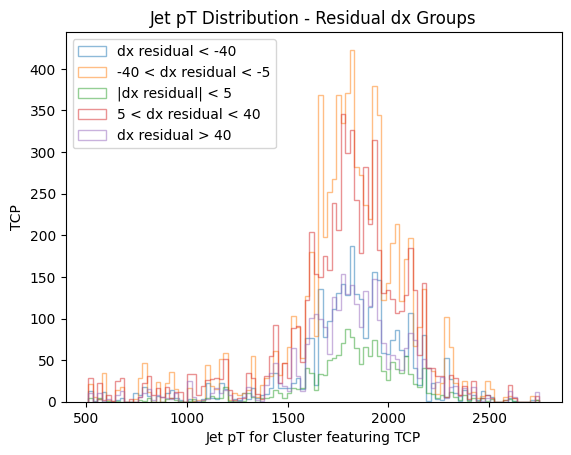

In [33]:
## target dx and dy's of the different positive, negative, and kernel dx_pred groups of pixels



def graphresiduals(threshold1, threshold2): #graphresiduals(small cutoff, large cutoff)
    
    superlow = []
    low = []
    acc = []
    high = []
    superhigh = []
    cutoff1 = threshold1
    cutoff2 = threshold2
    
    
    for i in range(N): # for each merged cluster
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > .7 and pixel_true_prob == 1): 
                        resid = 100*(validation_par[i,j,k,l,0] - chunk[1][0][i][j][k][l][0])
                        if (resid < -threshold2):
                            superlow.append(chunk[0][2][i])
                        if (resid < -threshold1 and resid > -threshold2):
                            low.append(chunk[0][2][i])
                        if (resid > -threshold1 and resid < threshold1):    
                            acc.append(chunk[0][2][i])
                        if (resid > threshold1 and resid < threshold2):    
                            high.append(chunk[0][2][i])
                        if (resid > threshold2): 
                            superhigh.append(chunk[0][2][i])
                            
                            
    plt.hist(superlow, bins=100, alpha=0.5, label='dx residual < -' + str(cutoff2), histtype = 'step')
    plt.hist(low, bins=100, alpha=0.5, label='-' + str(cutoff2) + ' < dx residual < -' + str(cutoff1), histtype = 'step')
    plt.hist(acc, bins=100, alpha=0.5, label='|dx residual| < ' + str(cutoff1), histtype = 'step')
    plt.hist(high, bins=100, alpha=0.5, label= str(cutoff1) + ' < dx residual < ' + str(cutoff2), histtype = 'step')
    plt.hist(superhigh, bins=100, alpha=0.5, label='dx residual > ' + str(cutoff2), histtype = 'step')
    plt.xlabel('Jet pT for Cluster featuring TCP')
    plt.ylabel('TCP')
    plt.title('Jet pT Distribution - Residual dx Groups')
    plt.legend()
    plt.show()
        
        
        
    

graphresiduals(5,40)

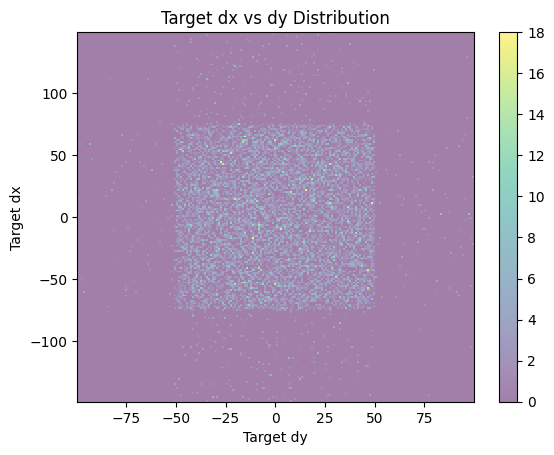

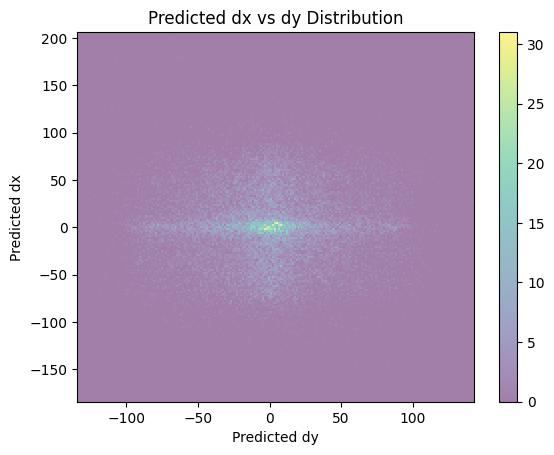

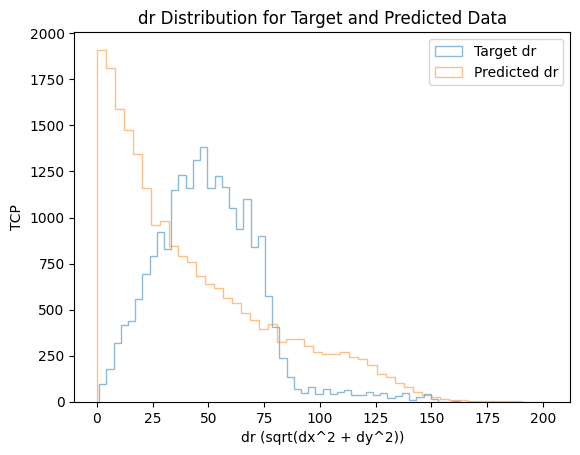

In [34]:
targdxs = []
targdys = []
preddxs = []
preddys = []
targdrs = []
preddrs = []



for i in range(N): # for each merged cluster
        for j in range(30): # for each x value
            for k in range(30): # for each y value
                for l in range(3): # for each track
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > .7 and pixel_true_prob == 1): 
                        targdxs.append(100*chunk[1][0][i][j][k][l][0])
                        targdys.append(100*chunk[1][0][i][j][k][l][1])
                        targdrs.append(np.sqrt((100*chunk[1][0][i][j][k][l][0])**2 + (100*chunk[1][0][i][j][k][l][1])**2))
                        preddxs.append(100*validation_par[i, j, k, l, 0])
                        preddys.append(100*validation_par[i, j, k, l, 1])
                        preddrs.append(np.sqrt((100*validation_par[i, j, k, l, 0])**2 + (100*validation_par[i, j, k, l, 0])**2))
                        
                        
heatmap, xedges, yedges, _ = plt.hist2d(targdxs, targdys, bins = 200, alpha = 0.5, cmap = 'viridis')
cbar = plt.colorbar()
plt.title("Target dx vs dy Distribution")
plt.ylabel("Target dx")
plt.xlabel("Target dy")
plt.show()

heatmap, xedges, yedges, _ = plt.hist2d(preddxs, preddys, bins = 200, alpha = 0.5, cmap = 'viridis')
cbar = plt.colorbar()
plt.title("Predicted dx vs dy Distribution")
plt.ylabel("Predicted dx")
plt.xlabel("Predicted dy")
plt.show()

plt.hist(targdrs, bins=50, alpha=0.5, label= 'Target dr', histtype = 'step')
plt.hist(preddrs, bins=50, alpha=0.5, label='Predicted dr', histtype = 'step')
plt.xlabel('dr (sqrt(dx^2 + dy^2))')
plt.ylabel('TCP')
plt.title('dr Distribution for Target and Predicted Data')
plt.legend()
plt.show()
